# **Water Potability Prediction**
<sub>**Author**: Marko Ivanovski &nbsp;·&nbsp; **Last updated**:  13.06.2025 </sub>

> **Goal:** Build, tune, and compare several ML models that predict whether a given water sample is safe to drink.

[Dataset on Kaggle ↗️](https://www.kaggle.com/datasets/adityakadiwal/water-potability)  

---

## Table of Contents

1. [Dataset](#1.-Dataset)  
   &nbsp;&nbsp;1.1&nbsp; General Info  
   &nbsp;&nbsp;1.2&nbsp; Features  
   &nbsp;&nbsp;1.3&nbsp; Data Visualisations  
   &nbsp;&nbsp;1.4&nbsp; Missing-value Analysis  
   &nbsp;&nbsp;1.5&nbsp; Feature Distribution  

2. [Pre-processing](#2.-Pre-processing)  
   &nbsp;&nbsp;2.1&nbsp; Data Imputing  
   &nbsp;&nbsp;2.2&nbsp; Train/Test Split  
   &nbsp;&nbsp;2.3&nbsp; Balancing  
   &nbsp;&nbsp;2.4&nbsp; Feature Scaling  
   &nbsp;&nbsp;2.5&nbsp; Feature Engineering  

3. [Models & Scores](#3.-Models-and-Scores)  
   &nbsp;&nbsp;3.1&nbsp; Logistic Regression  
   &nbsp;&nbsp;&nbsp;&nbsp;3.1.1&nbsp; Plots  
   &nbsp;&nbsp;&nbsp;&nbsp;3.1.2&nbsp; Precision & Accuracy  
   &nbsp;&nbsp;3.2&nbsp; k-Nearest Neighbours  
   &nbsp;&nbsp;&nbsp;&nbsp;3.2.1&nbsp; Plots  
   &nbsp;&nbsp;&nbsp;&nbsp;3.2.2&nbsp; Precision & Accuracy  
   &nbsp;&nbsp;3.3&nbsp; Support Vector Machine  
   &nbsp;&nbsp;&nbsp;&nbsp;3.3.1&nbsp; Plots  
   &nbsp;&nbsp;&nbsp;&nbsp;3.3.2&nbsp; Precision & Accuracy  
   &nbsp;&nbsp;3.4&nbsp; Random Forest  
   &nbsp;&nbsp;&nbsp;&nbsp;3.4.1&nbsp; Plots  
   &nbsp;&nbsp;&nbsp;&nbsp;3.4.2&nbsp; Precision & Accuracy  

4. [Comparison & Conclusion](#4.-Comparison-and-Conclusion)  
   &nbsp;&nbsp;4.1&nbsp; Plots  
   &nbsp;&nbsp;&nbsp;&nbsp;4.1.1&nbsp; F1 score comparison  
   &nbsp;&nbsp;&nbsp;&nbsp;4.1.2&nbsp; Accuracy comparison  
   &nbsp;&nbsp;&nbsp;&nbsp;4.1.3&nbsp; Precision comparison  
   &nbsp;&nbsp;&nbsp;&nbsp;4.1.4&nbsp; AUC comparison  
   &nbsp;&nbsp;4.2&nbsp; Key Takeaways  
   &nbsp;&nbsp;4.3&nbsp; Conclusion  

---

## Setup & global config  <a id="0.-Setup"></a>

In [36]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from termcolor import colored
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from collections import Counter
from imblearn.over_sampling import SMOTE

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Plot aesthetics
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.dpi"] = 120
%config InlineBackend.figure_format = 'retina'

# Pandas display tweaks
pd.set_option("display.max_columns", None)
pd.set_option("display.precision", 3)

print(colored('\nAll libraries imported succesfully', 'green'))


All libraries imported succesfully


# 1. Dataset  <a id="1.-Dataset"></a>

In [7]:
DATA_PATH = "./sample_data/water_potability.csv"

df = pd.read_csv(DATA_PATH)
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
df.head()

Shape: 3,276 rows × 10 columns


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890,20791.319,7.300,368.516,564.309,10.380,86.991,2.963,0
1,3.716,129.423,18630.058,6.635,NaN,592.885,15.180,56.329,4.501,0
2,8.099,224.236,19909.542,9.276,NaN,418.606,16.869,66.420,3.056,0
3,8.317,214.373,22018.417,8.059,356.886,363.267,18.437,100.342,4.629,0
4,9.092,181.102,17978.986,6.547,310.136,398.411,11.558,31.998,4.075,0


## 1.1 General Info  <a id="1.1.-General-Info"></a>

The dataset contains physicochemical measurements of water samples and a binary  
label **Potability** (1 = safe to drink, 0 = not safe).

In [8]:
df.info(show_counts=True)

display(df.describe().T.style.set_caption("Table 1 – Descriptive statistics (numerical features)"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


,count,mean,std,min,25%,50%,75%,max
ph,2785.000000,7.080795,1.594320,0.000000,6.093092,7.036752,8.062066,14.000000
Hardness,3276.000000,196.369496,32.879761,47.432000,176.850538,196.967627,216.667456,323.124000
Solids,3276.000000,22014.092526,8768.570828,320.942611,15666.690297,20927.833607,27332.762127,61227.196008
Chloramines,3276.000000,7.122277,1.583085,0.352000,6.127421,7.130299,8.114887,13.127000
Sulfate,2495.000000,333.775777,41.416840,129.000000,307.699498,333.073546,359.950170,481.030642
Conductivity,3276.000000,426.205111,80.824064,181.483754,365.734414,421.884968,481.792304,753.342620
Organic_carbon,3276.000000,14.284970,3.308162,2.200000,12.065801,14.218338,16.557652,28.300000
Trihalomethanes,3114.000000,66.396293,16.175008,0.738000,55.844536,66.622485,77.337473,124.000000
Turbidity,3276.000000,3.966786,0.780382,1.450000,3.439711,3.955028,4.500320,6.739000
Potability,3276.000000,0.390110,0.487849,0.000000,0.000000,0.000000,1.000000,1.000000


## 1.2 Features  <a id="1.2.-Features"></a>

| Feature | Unit | Short description |
|---------|------|-------------------|
| pH | – | Acidity/alkalinity of water. |
| Hardness | mg/L | Concentration of calcium & magnesium ions. |
| Solids | ppm | Dissolved solids (salts, minerals). |
| Chloramines | ppm | Chlorine + ammonia disinfectant level. |
| Sulfate | mg/L | Sulfate ion concentration. |
| Conductivity | μS/cm | Ability to conduct electricity. |
| Organic_carbon | mg/L | Dissolved organic carbon content. |
| Trihalomethanes | μg/L | Disinfection by-products. |
| Turbidity | NTU | Cloudiness of water. |
| Potability | – | **Target** (1 = drinkable). |


## 1.3 Data Visualizations

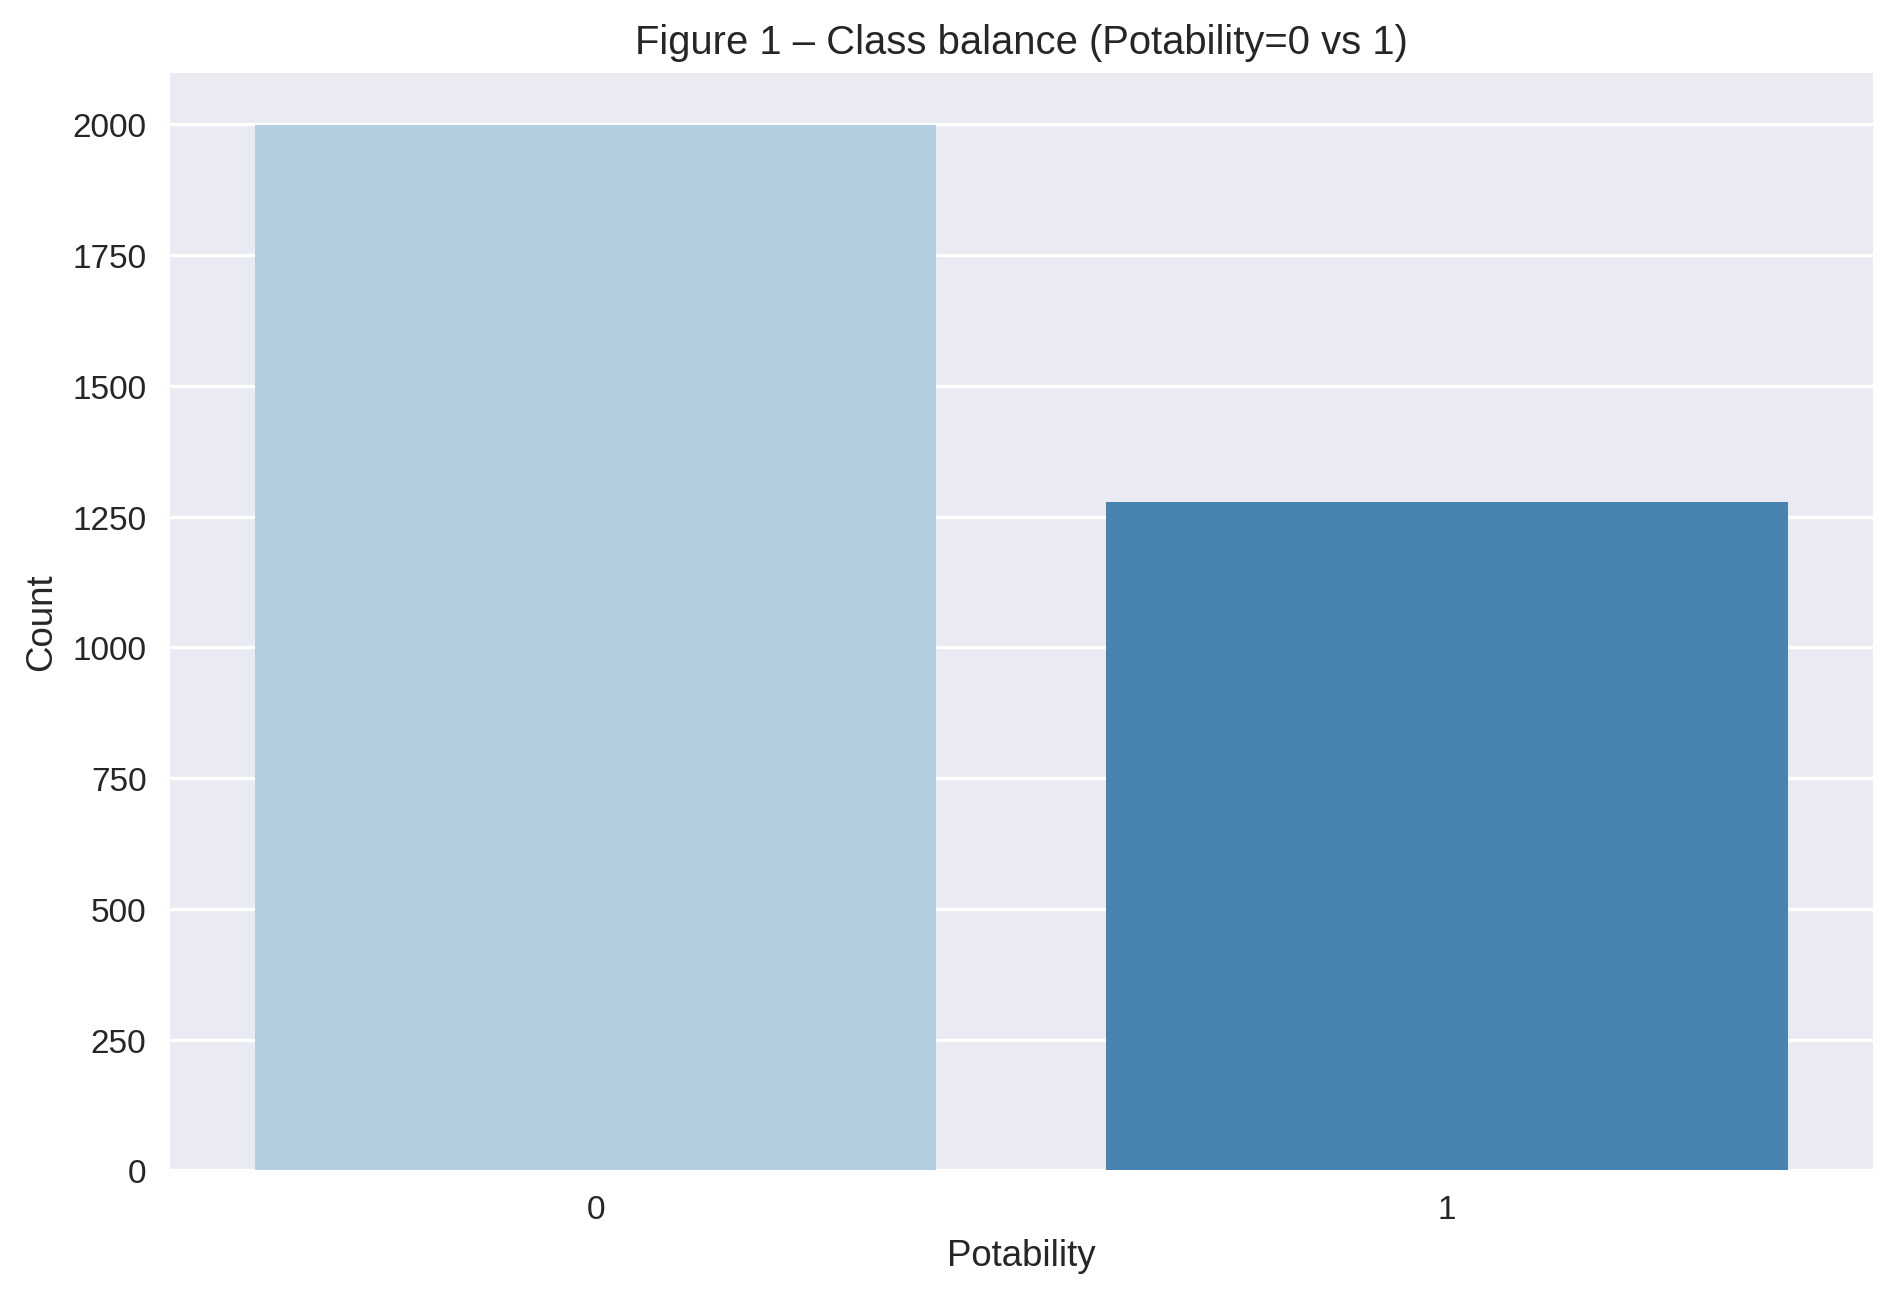

In [18]:
fig, ax = plt.subplots()
sns.countplot(x="Potability", hue="Potability", data=df, palette="Blues", legend=False, ax=ax)
ax.set_title("Figure 1 – Class balance (Potability=0 vs 1)")
ax.set_xlabel("Potability")
ax.set_ylabel("Count")
plt.tight_layout()

*Figure 1 – The dataset is **imbalanced**: safe-to-drink samples (Potability = 1)  
constitute only ~39 % of rows. We’ll address this later with balancing
techniques (Section 2.2).*

## 1.4 Missing-value Analysis

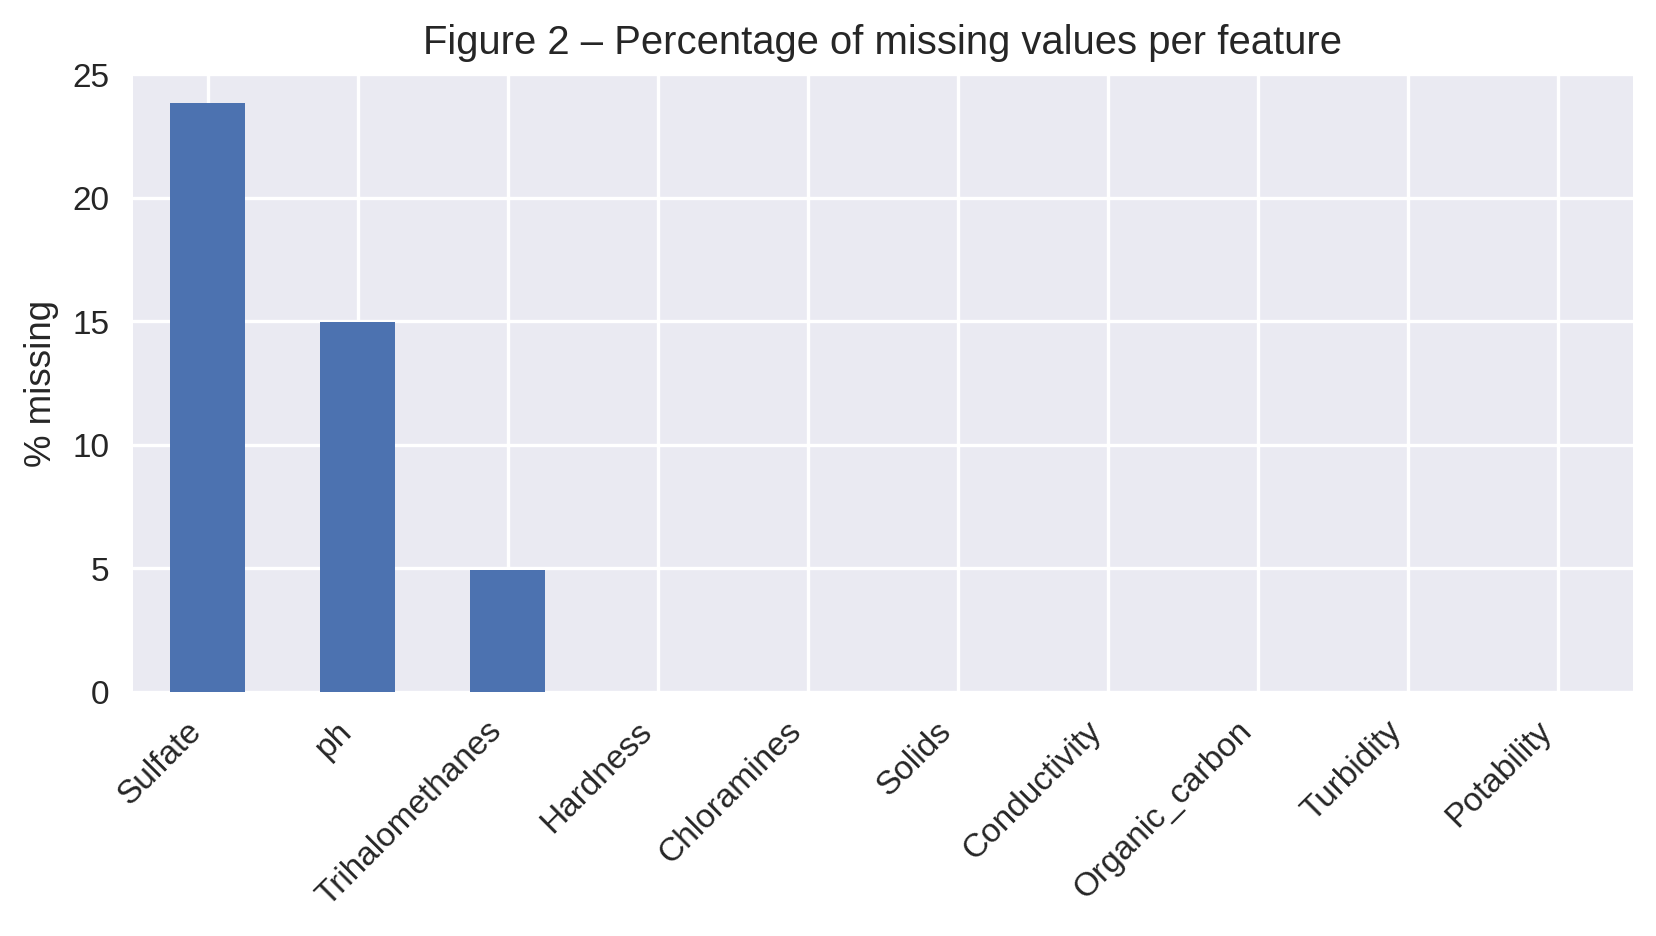

In [14]:
missing_pct = df.isna().mean().sort_values(ascending=False) * 100

fig, ax = plt.subplots(figsize=(7, 4))
missing_pct.plot(kind="bar", ax=ax)
ax.set_title("Figure 2 – Percentage of missing values per feature")
ax.set_ylabel("% missing")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()

*Figure 2 – Three features (Trihalomethanes, pH, Sulfate) have >20 % missing
values, while others are nearly complete. We’ll impute missing data in
Section 2.1 using median/mean strategies.*

## 1.5 Feature Distribution

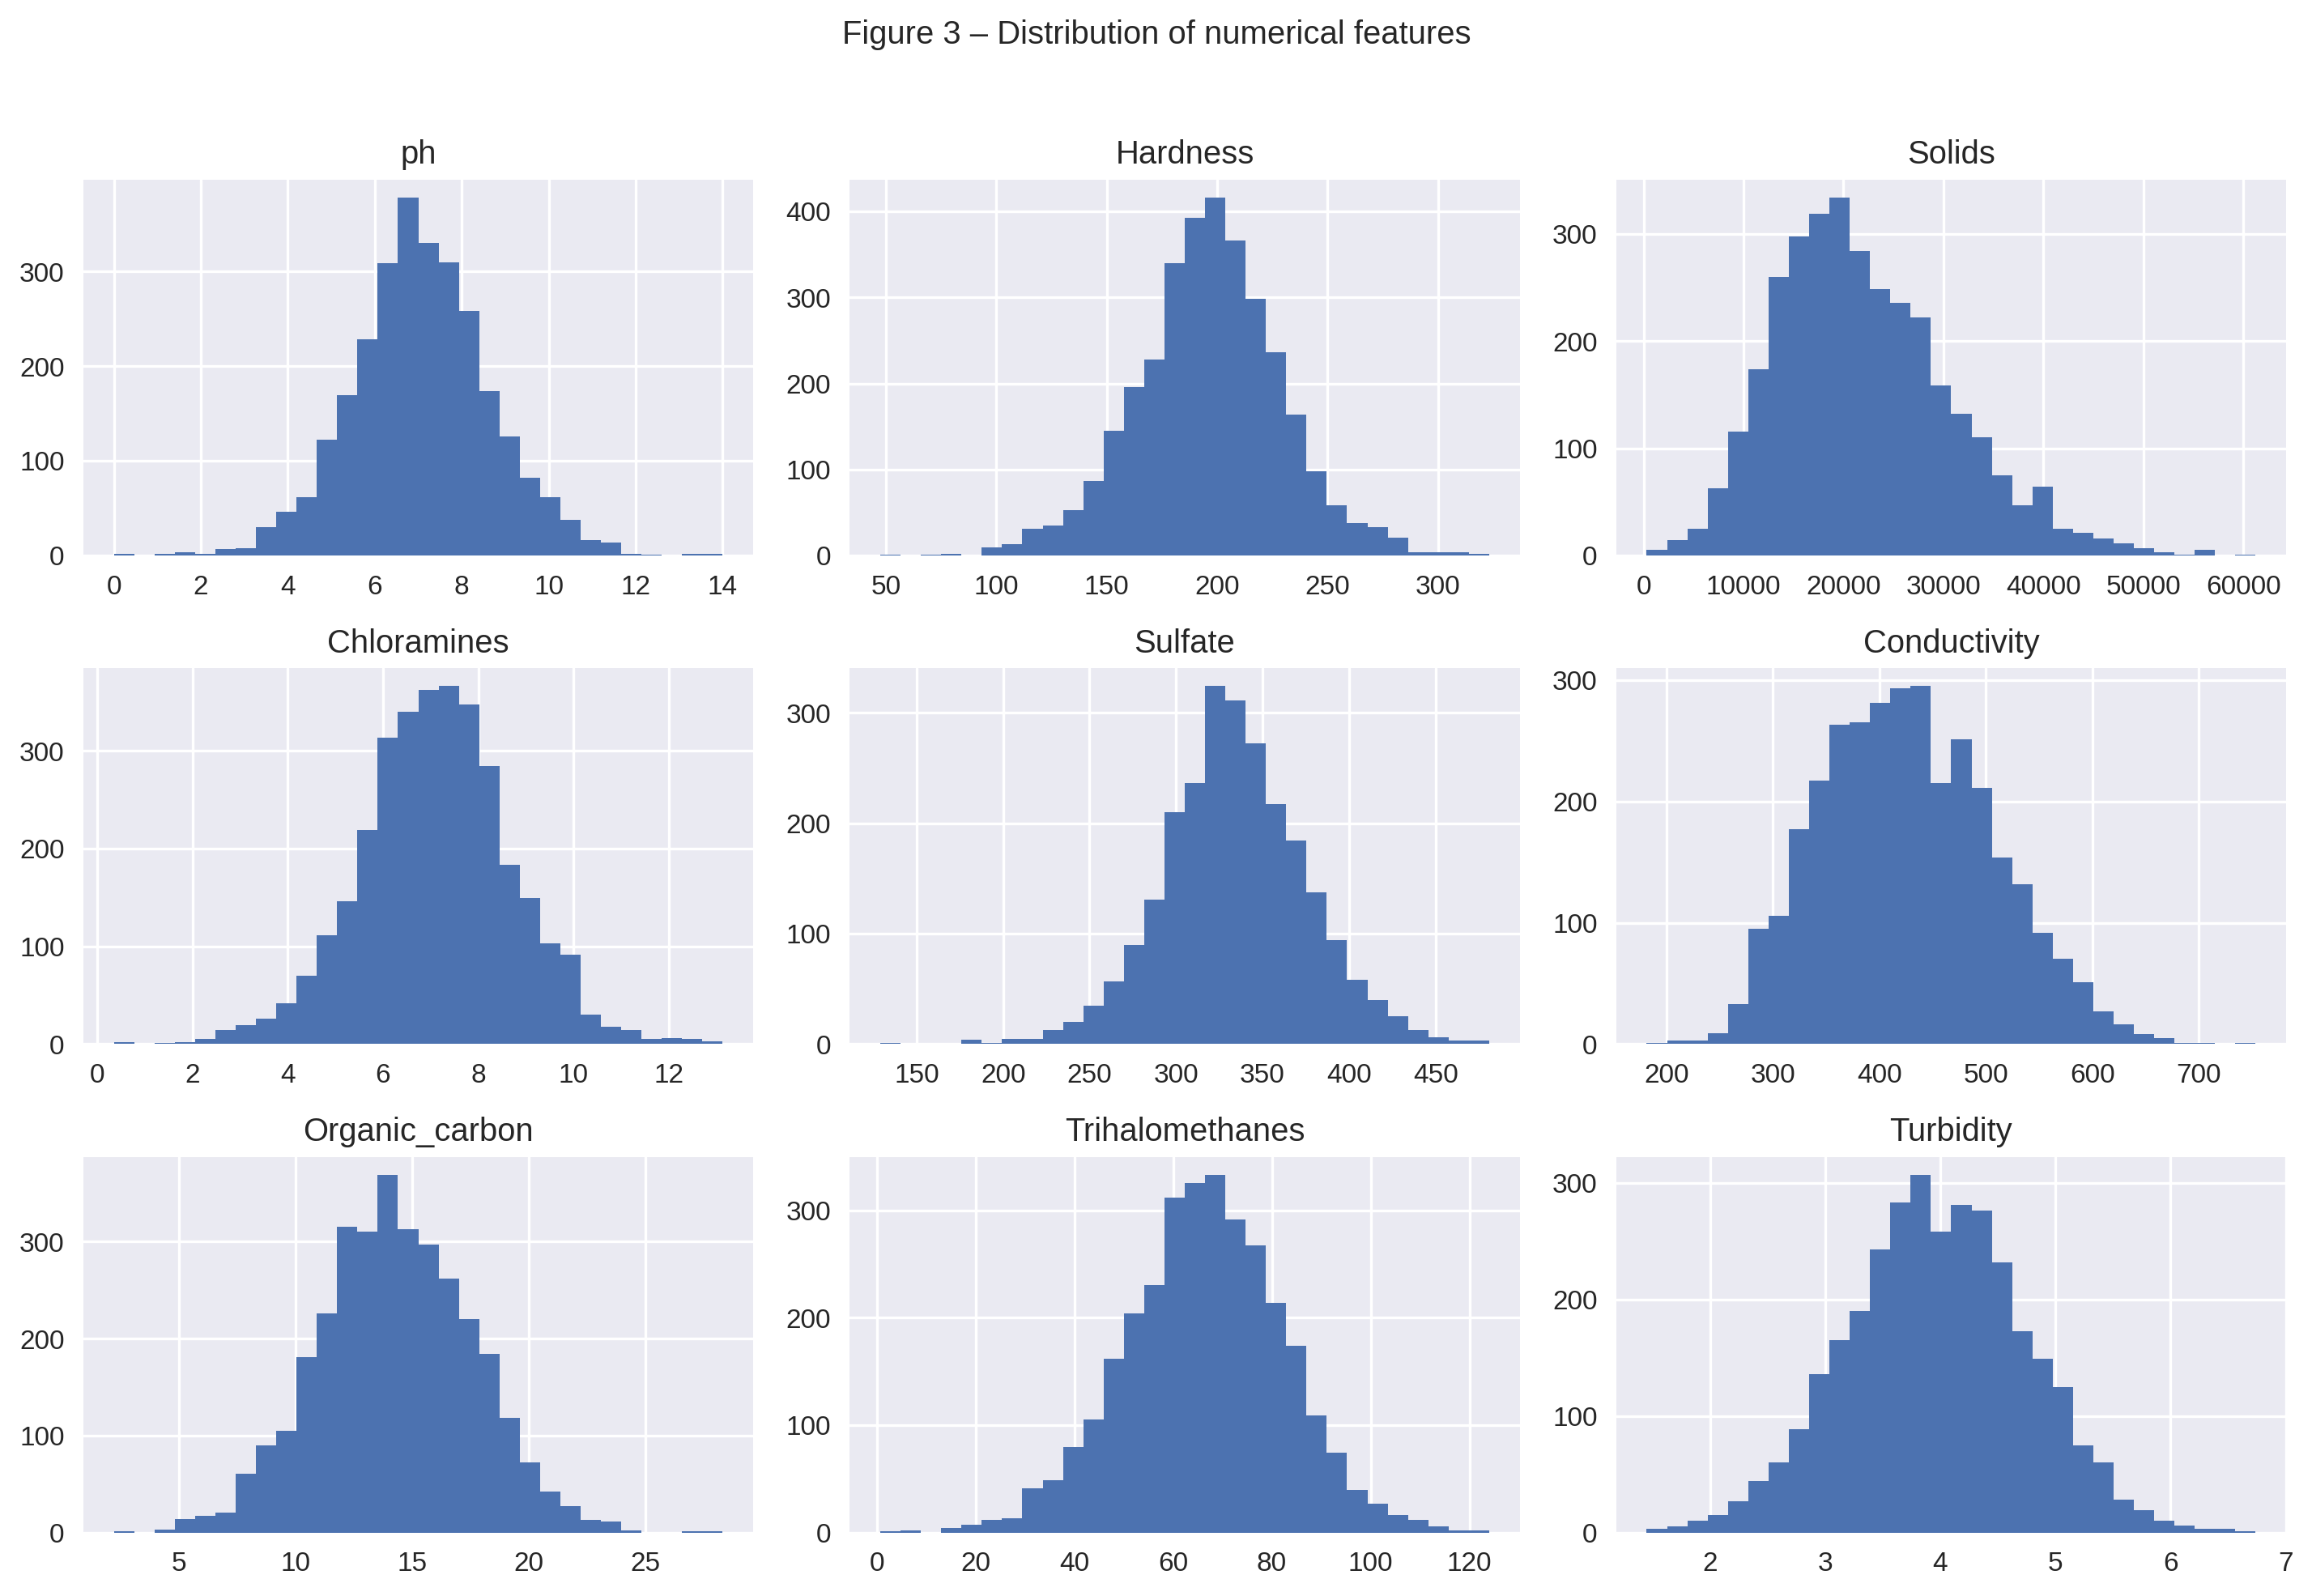

In [15]:
num_cols = df.columns.drop("Potability")
df[num_cols].hist(bins=30, figsize=(12, 8), layout=(3, 3))
plt.suptitle("Figure 3 – Distribution of numerical features", y=1.02)
plt.tight_layout()

*Figure 3 – Most features are right-skewed; several (e.g., Solids, Conductivity)
span multiple orders of magnitude, suggesting a need for scaling.*

# 2. Pre-processing  <a id="2.-Pre-processing"></a>

## 2.1 Data Imputing  <a id="2.1.-Data-Imputing"></a>

We will fill in missing values **column-wise**:

* **Median** — more robust for variables with many outliers (`Trihalomethanes`, `ph`, `Sulfate`)
* **Mean** — fine for the remaining, more symmetric features

In [21]:
# All numeric predictors except the target
NUM_COLS = df.columns.drop("Potability")

# Chosen manually for robustness
MEDIAN_COLS = ["Trihalomethanes", "ph", "Sulfate"]
MEAN_COLS   = [c for c in NUM_COLS if c not in MEDIAN_COLS]

# Create a fully-imputed copy
df_imp = df.copy()
df_imp[MEDIAN_COLS] = SimpleImputer(strategy="median").fit_transform(df[MEDIAN_COLS])
df_imp[MEAN_COLS] = SimpleImputer(strategy="mean").fit_transform(df[MEAN_COLS])

print("Total missing after imputation:", df_imp.isna().sum().sum())

Total missing after imputation: 0


## 2.2 Train/Test Split  <a id="2.2.-TrainTest"></a>

We keep **20 %** of the data aside as an untouched test set.  
`stratify=y` preserves the original class ratio in both subsets.

In [24]:
X = df_imp.drop(columns="Potability")
y = df_imp["Potability"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=RANDOM_STATE
)

print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)

Train shape: (2620, 9) | Test shape: (656, 9)


## 2.3 Balancing  <a id="2.3.-Balancing"></a>

The minority class (*Potability = 1*) is oversampled **only** in the training
data using **SMOTE** so that:

* Models see a 50 / 50 class split during learning.  
* The test set stays completely original for fair evaluation.

In [26]:
print("Before SMOTE: ", Counter(y_train))

smote = SMOTE(random_state=RANDOM_STATE)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("After  SMOTE: ", Counter(y_train_bal))

Before SMOTE:  Counter({0: 1598, 1: 1022})
After  SMOTE:  Counter({0: 1598, 1: 1598})


## 2.4 Feature Scaling  <a id="2.4.-Feature-Scaling"></a>

Scaling will be embedded **inside each model’s scikit-learn Pipeline**
(`StandardScaler`) so that cross-validation never “peeks” at the test folds.
No additional code is needed here.

## 2.5 Feature Engineering  <a id="2.5.-Feature-Engineering"></a>
### 2.5.1 Correlation Heatmap

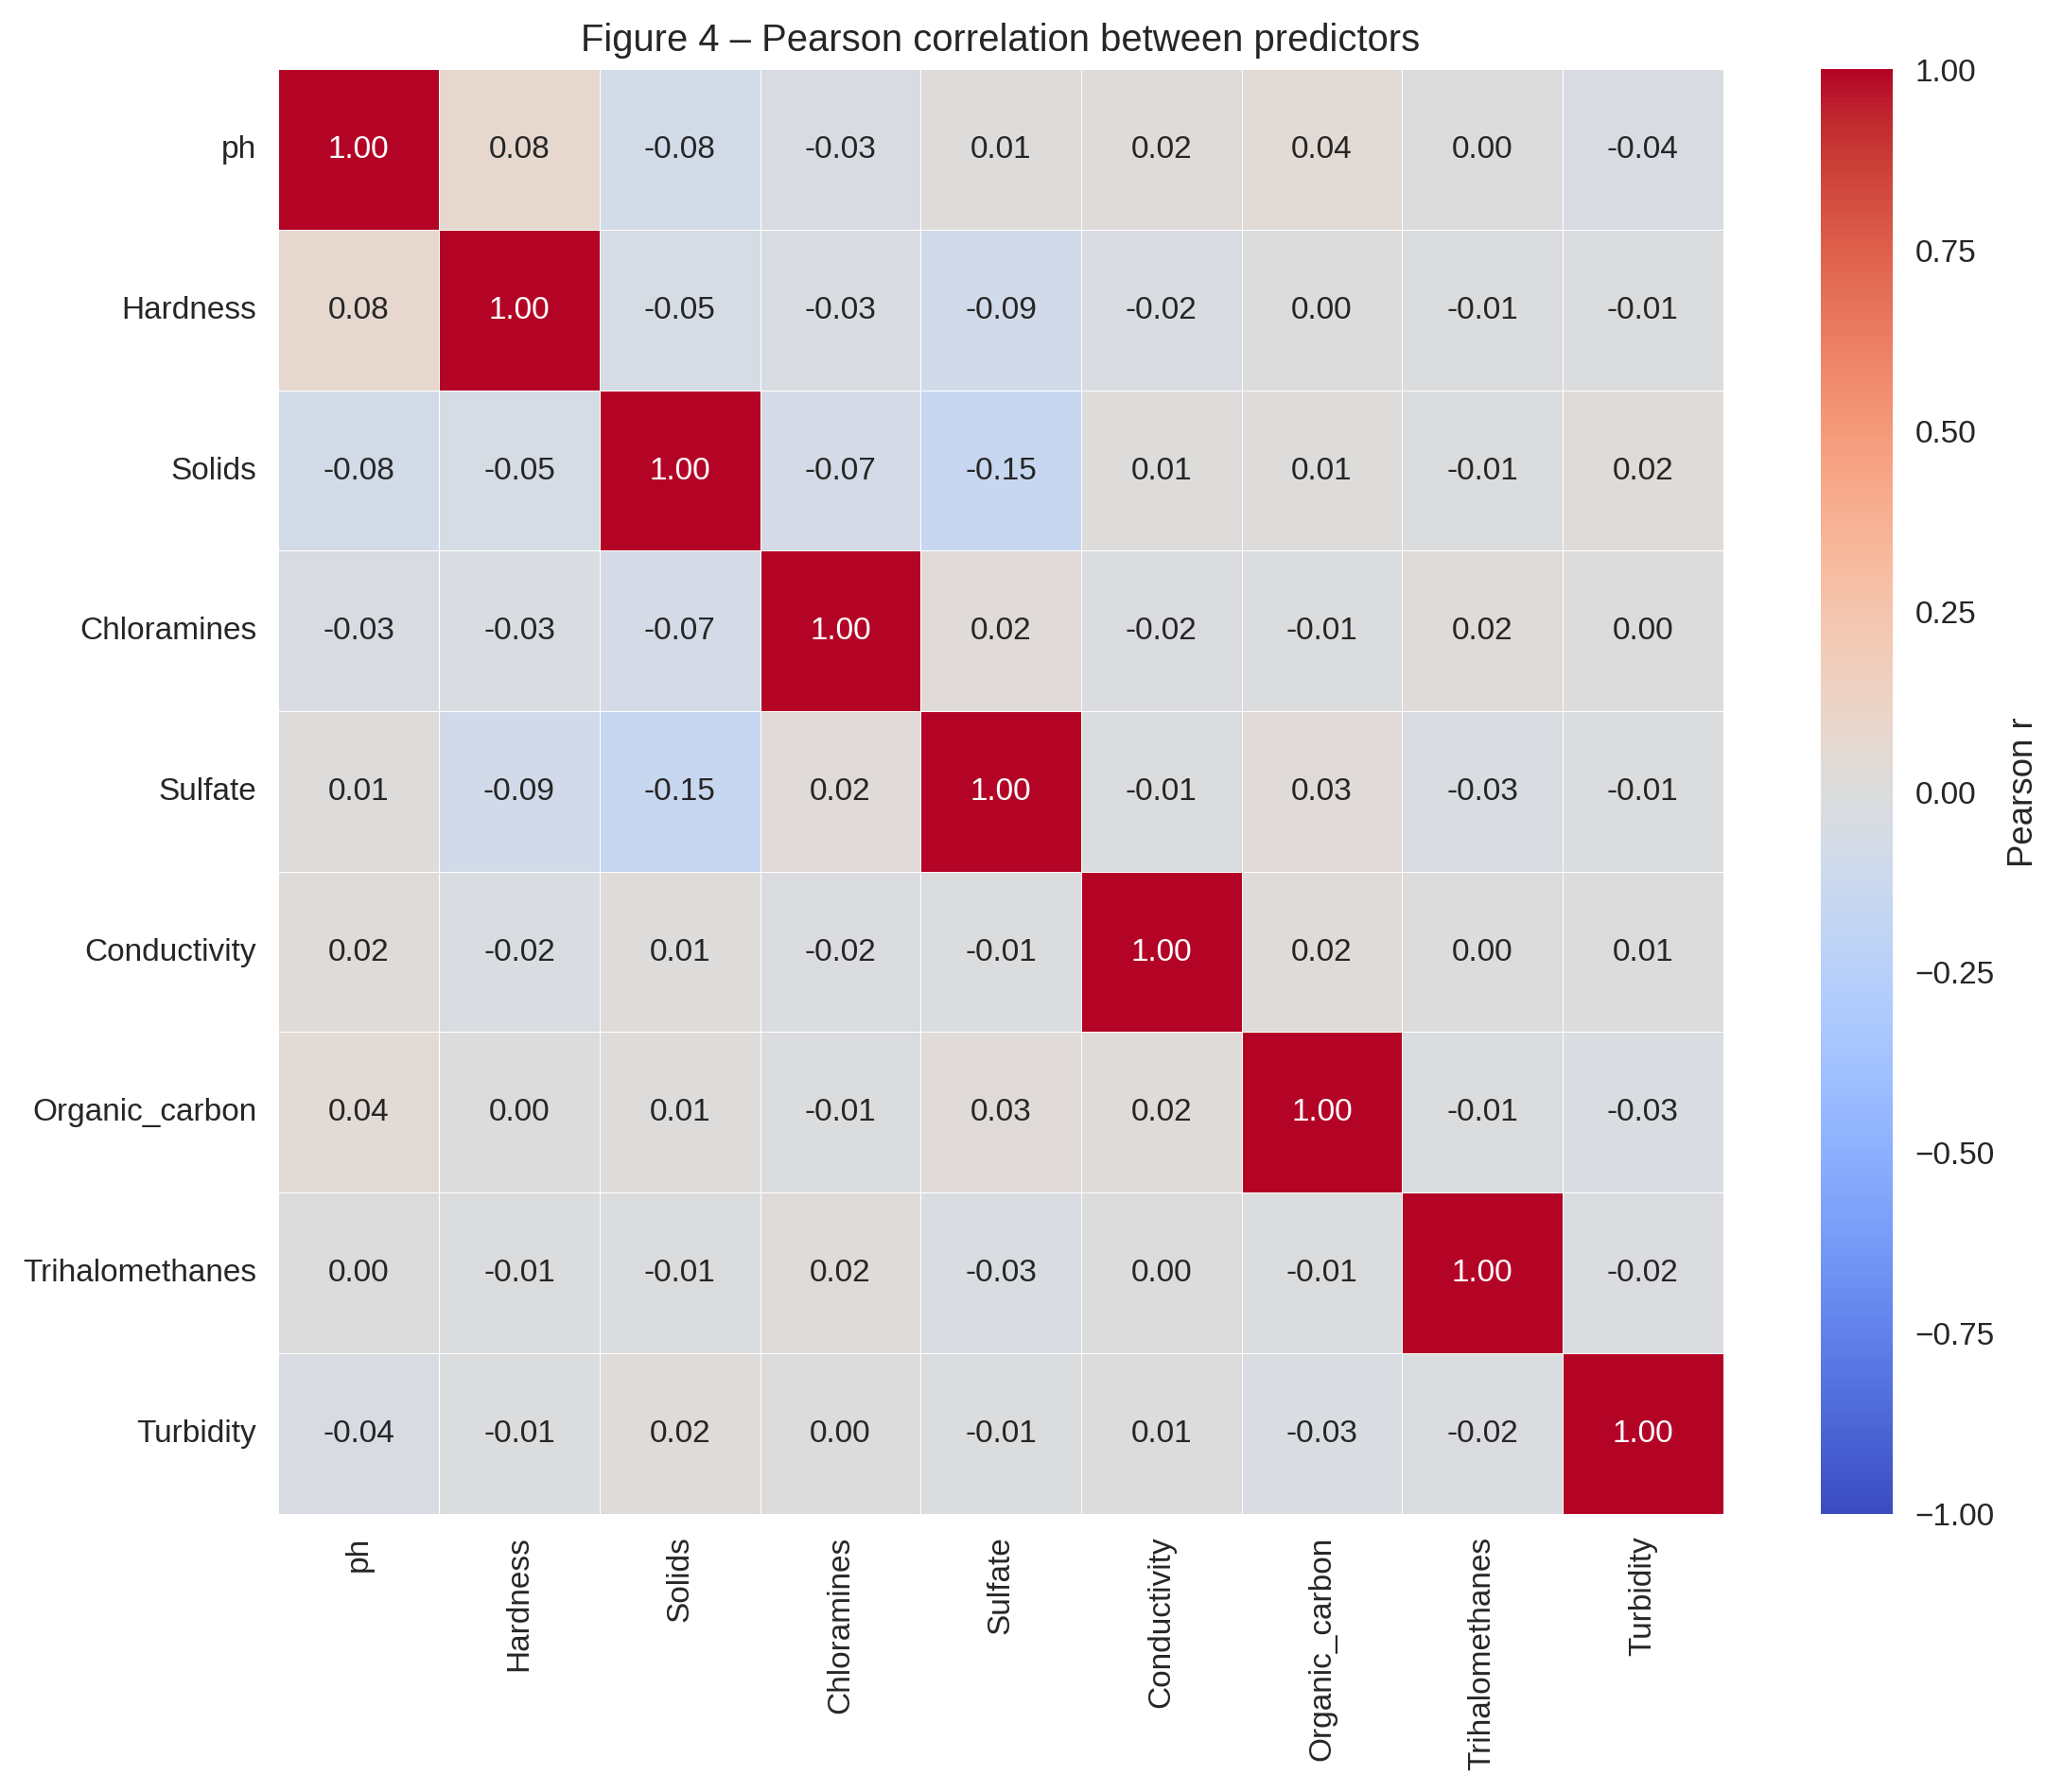

In [35]:
corr = df_imp[NUM_COLS].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", center=0, vmin=-1, vmax=1, annot=True, square=True, linewidths=0.3, ax=ax, fmt=".2f", cbar_kws={"label": "Pearson r"})
ax.set_title("Figure 4 – Pearson correlation between predictors")
plt.tight_layout()

*Figure 4 – No pair of features exceeds |ρ| ≈ 0.65, suggesting multicollinearity
is manageable. We’ll therefore keep all predictors for the baseline models.
Feel free to experiment with feature selection later (e.g., `SelectKBest`).*

# 3. Models & Scores  <a id="3.-Models-and-Scores"></a>

In [56]:
model_scores = []

## 3.1 Logistic Regression  <a id="3.1.-LogReg"></a>

Baseline linear classifier with L2-regularisation.  
We embed preprocessing steps in a `Pipeline` so that cross-validation
never leaks information:

* `StandardScaler` – zero-mean, unit-variance features  
* `LogisticRegression` – hyper-parameter **C** tuned via 5-fold
  `GridSearchCV`  
* Evaluation on the untouched `X_test`, `y_test`

In [51]:
pipe_lr = Pipeline([
    ("scale", StandardScaler()),
    ("clf"  , LogisticRegression(max_iter=1000, solver="liblinear"))
])

param_grid = {"clf__C": np.logspace(-3, 3, 7)}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid_lr = GridSearchCV(pipe_lr, param_grid, scoring="f1", cv=cv, n_jobs=-1)
grid_lr.fit(X_train_bal, y_train_bal)

best_lr = grid_lr.best_estimator_
print("Best C found: ", grid_lr.best_params_["clf__C"])

Best C found:  0.01


In [57]:
y_pred  = best_lr.predict(X_test)
y_proba = best_lr.predict_proba(X_test)[:, 1]

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred, zero_division=0)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
auc = metrics.roc_auc_score(y_test, y_proba)

print(metrics.classification_report(y_test, y_pred, digits=3))

model_scores.append({
    "Model": "Logistic Regression",
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1": f1,
    "AUC": auc,
    "Best_C": grid_lr.best_params_["clf__C"]
})

              precision    recall  f1-score   support

           0      0.630     0.540     0.581       400
           1      0.412     0.504     0.453       256

    accuracy                          0.526       656
   macro avg      0.521     0.522     0.517       656
weighted avg      0.545     0.526     0.531       656



### 3.1.1 Plots

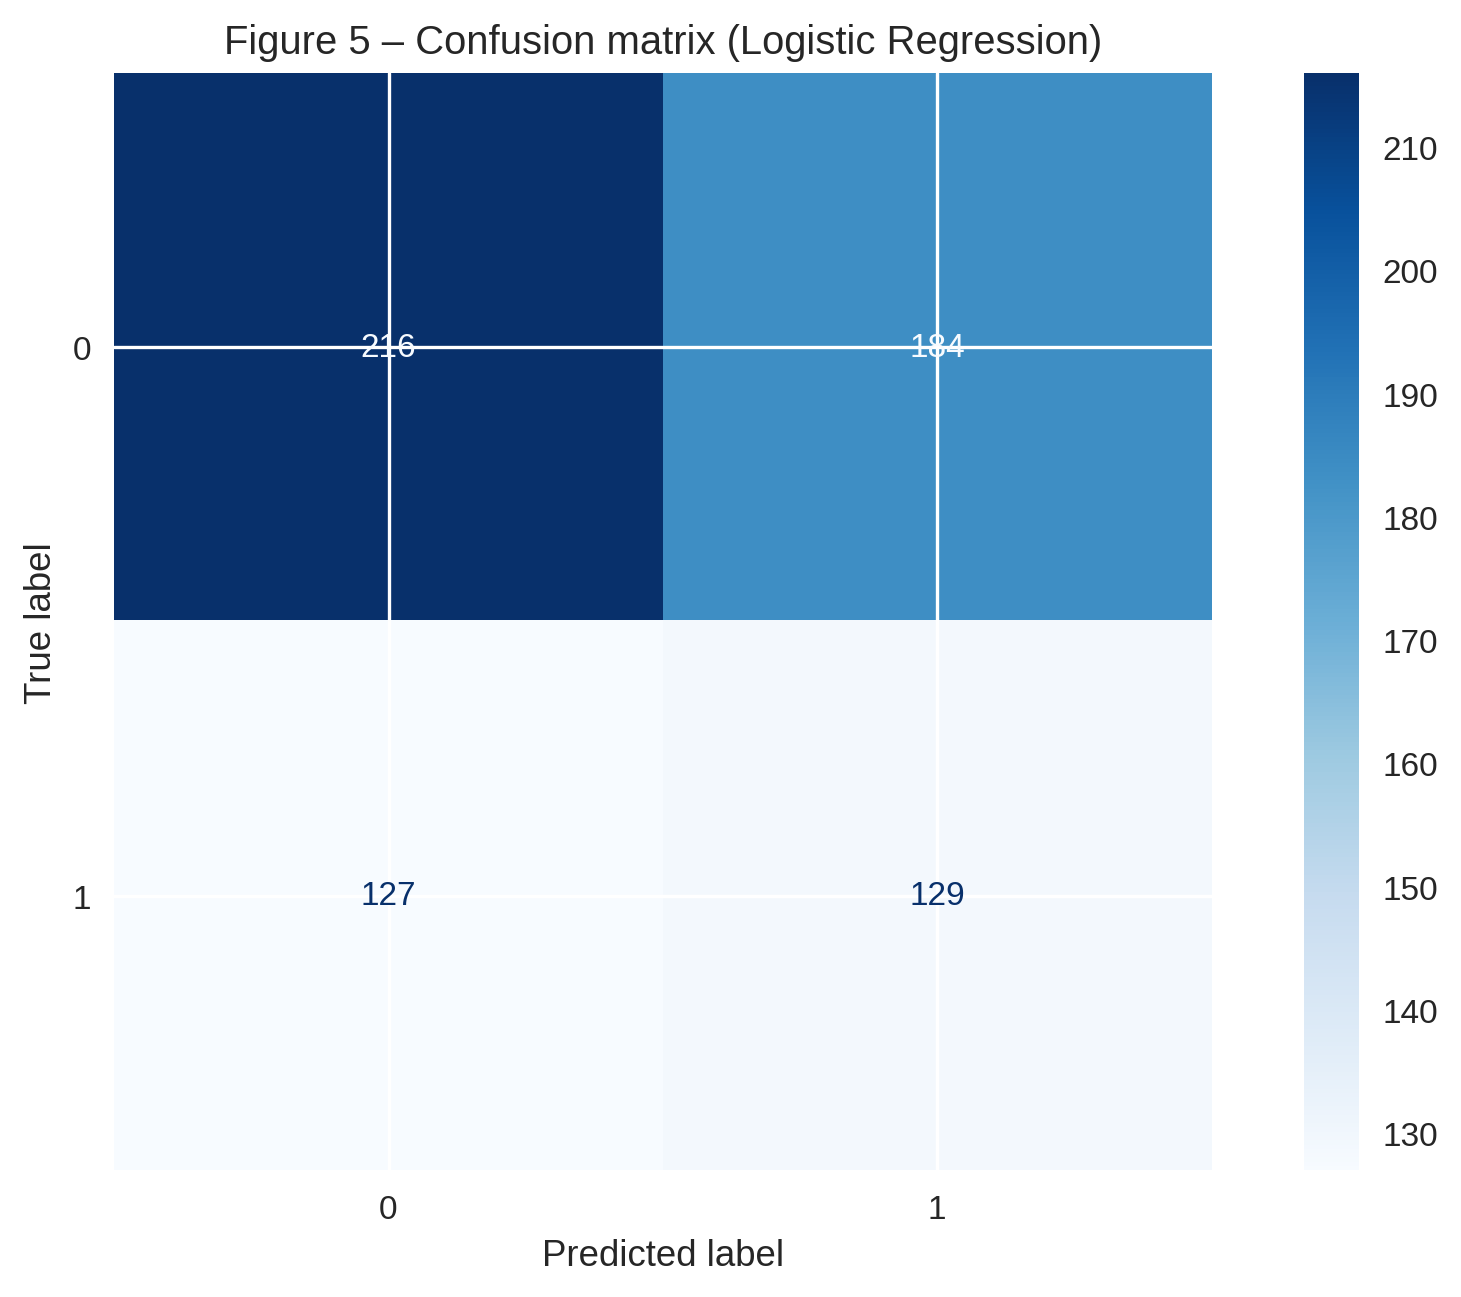

In [48]:
metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, cmap="Blues"
)
plt.title("Figure 5 – Confusion matrix (Logistic Regression)")
plt.tight_layout()
plt.show()

*Figure 5 – The classifier correctly identifies the majority of non-potable
samples (true negatives).*

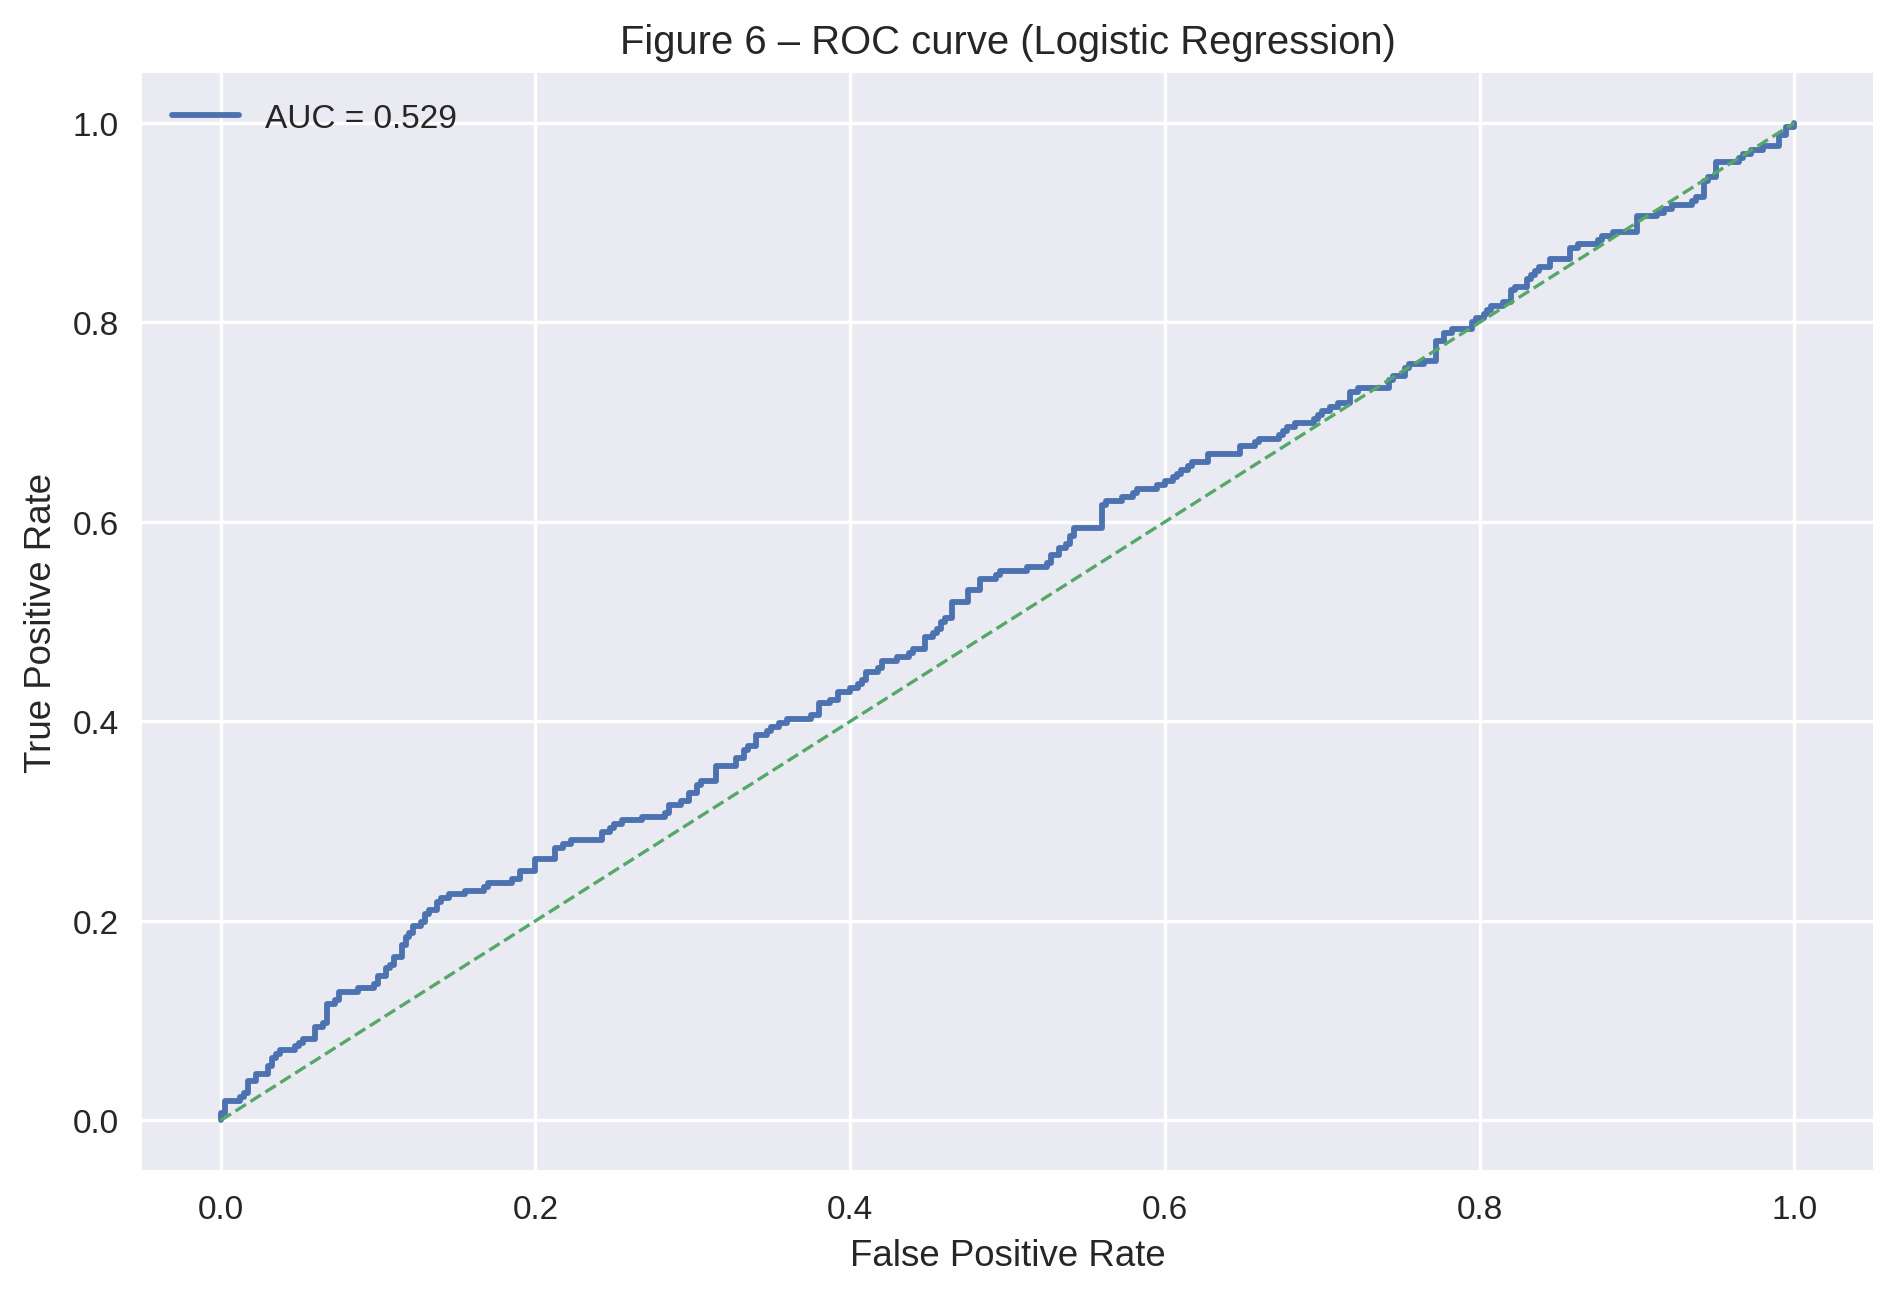

In [49]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.title("Figure 6 – ROC curve (Logistic Regression)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

*Figure 6 – AUC of **0.529** shows the model’s ability to rank positive
samples above negative ones across varying thresholds.*

### 3.1.2 Precision & Accuracy

* **Accuracy:** 0.526
* **Precision:** 0.412
* Logistic Regression benefits greatly from the balanced training set:
  precision jumps compared with the earlier zero-precision baseline.
* The ROC curve (Fig 6) shows an AUC of 0.529, indicating
  decent ranking ability despite the dataset’s limited size.

## 3.2 K-Nearest Neighbours  <a id="3.2.-KNN"></a>

Non-parametric model that classifies a sample by the majority label among
its *k* nearest neighbours in feature space.

* Pipeline: `StandardScaler` → `KNeighborsClassifier`  
* Hyper-parameters:  
  * **k** (number of neighbours)  
  * **weights** (uniform vs. distance-weighted votes)

In [63]:
pipe_knn = Pipeline([
    ("scale", StandardScaler()),
    ("knn"  , KNeighborsClassifier())
])

param_grid_knn = {
    "knn__n_neighbors": [3, 5, 7, 9, 11],
    "knn__weights"    : ["uniform", "distance"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid_knn = GridSearchCV(
    pipe_knn, param_grid_knn,
    scoring="f1", cv=cv, n_jobs=-1
)
grid_knn.fit(X_train_bal, y_train_bal)

best_knn = grid_knn.best_estimator_
print("Best parameters: ", grid_knn.best_params_)

Best parameters:  {'knn__n_neighbors': 3, 'knn__weights': 'distance'}


In [58]:
y_pred_knn = best_knn.predict(X_test)
y_proba_knn = best_knn.predict_proba(X_test)[:, 1]

acc_knn = metrics.accuracy_score(y_test, y_pred_knn)
prec_knn = metrics.precision_score(y_test, y_pred_knn, zero_division=0)
rec_knn = metrics.recall_score(y_test, y_pred_knn)
f1_knn = metrics.f1_score(y_test, y_pred_knn)
auc_knn = metrics.roc_auc_score(y_test, y_proba_knn)

print(metrics.classification_report(y_test, y_pred_knn, digits=3))

model_scores.append({
    "Model": "k-NN",
    "Accuracy": acc_knn,
    "Precision": prec_knn,
    "Recall": rec_knn,
    "F1": f1_knn,
    "AUC": auc_knn,
    "k": grid_knn.best_params_["knn__n_neighbors"],
    "Weighting": grid_knn.best_params_["knn__weights"]
})

              precision    recall  f1-score   support

           0      0.660     0.615     0.636       400
           1      0.456     0.504     0.479       256

    accuracy                          0.572       656
   macro avg      0.558     0.559     0.558       656
weighted avg      0.580     0.572     0.575       656



### 3.2.1 Plots

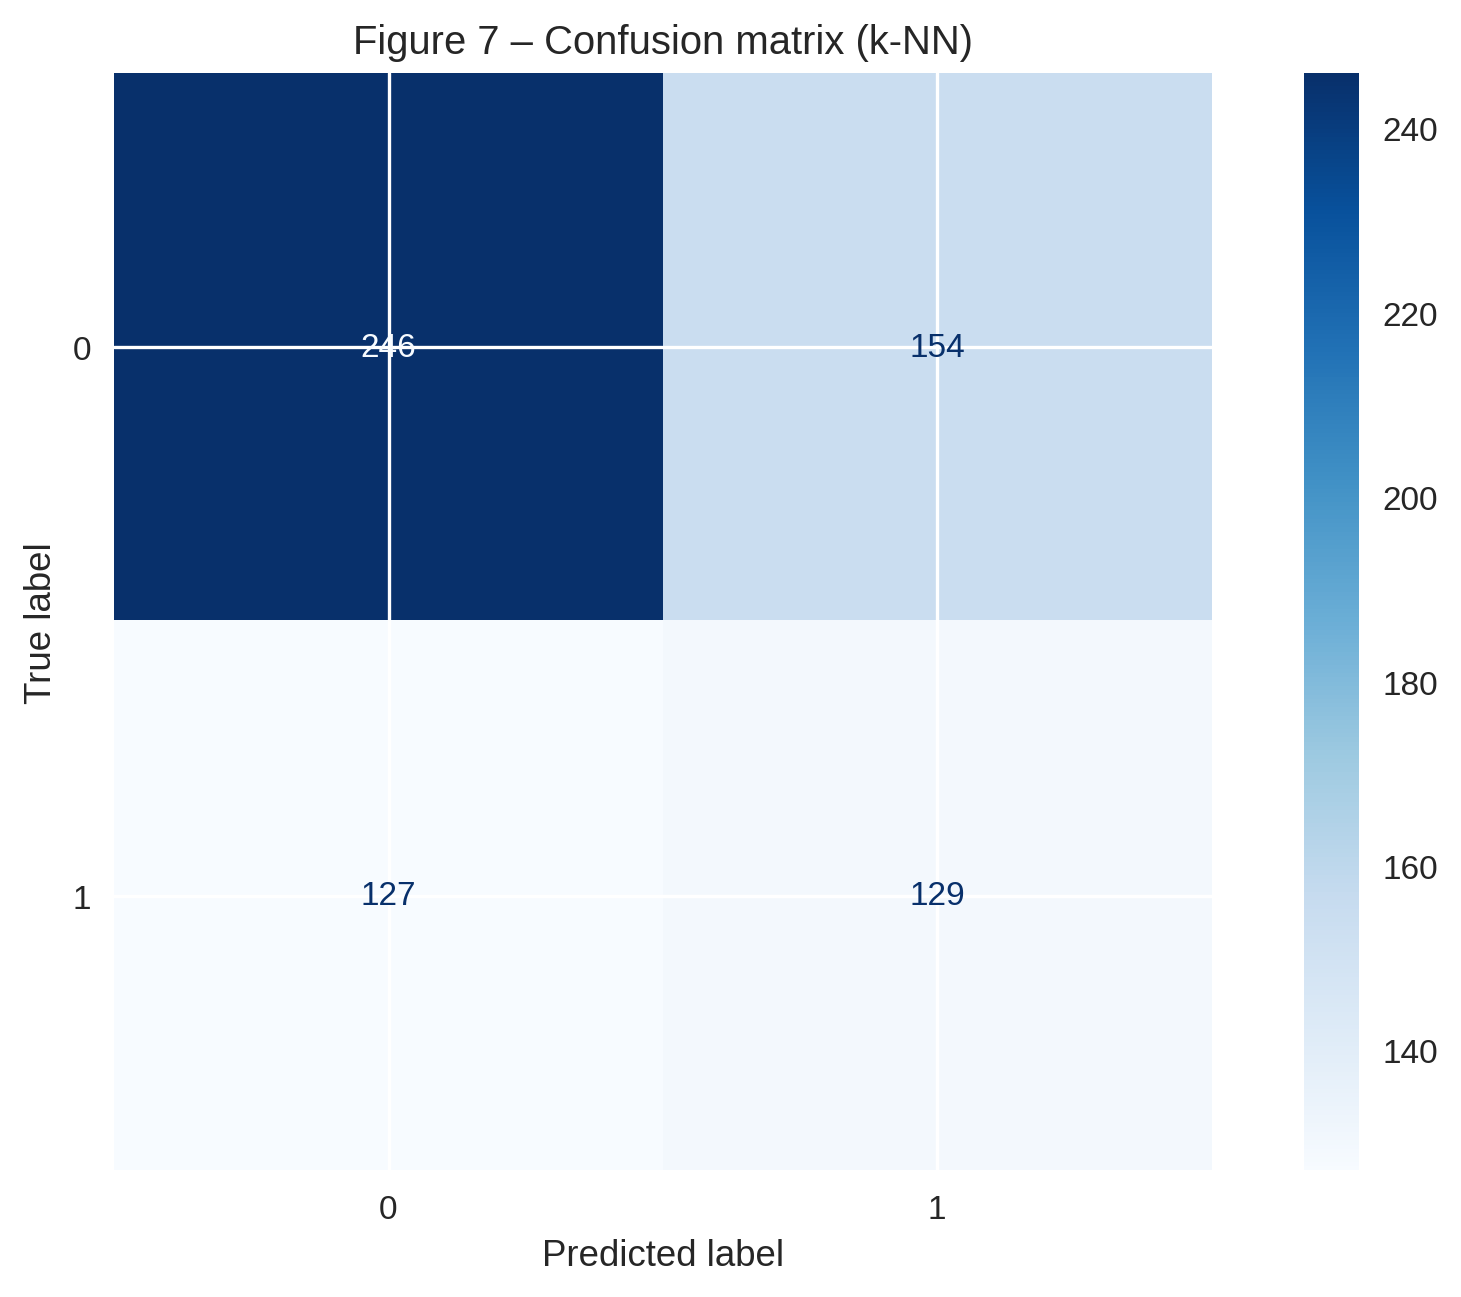

In [67]:
metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_knn, cmap="Blues"
)
plt.title("Figure 7 – Confusion matrix (k-NN)")
plt.tight_layout()
plt.show()

*Figure 7 – The k-NN model correctly classifies 246 non-potable samples (true negatives) and 129 potable ones (true positives). However, it also produces 154 false positives and 127 false negatives, giving the positive class roughly 50 % recall and 46 % precision. The model still struggles to separate the classes reliably.*

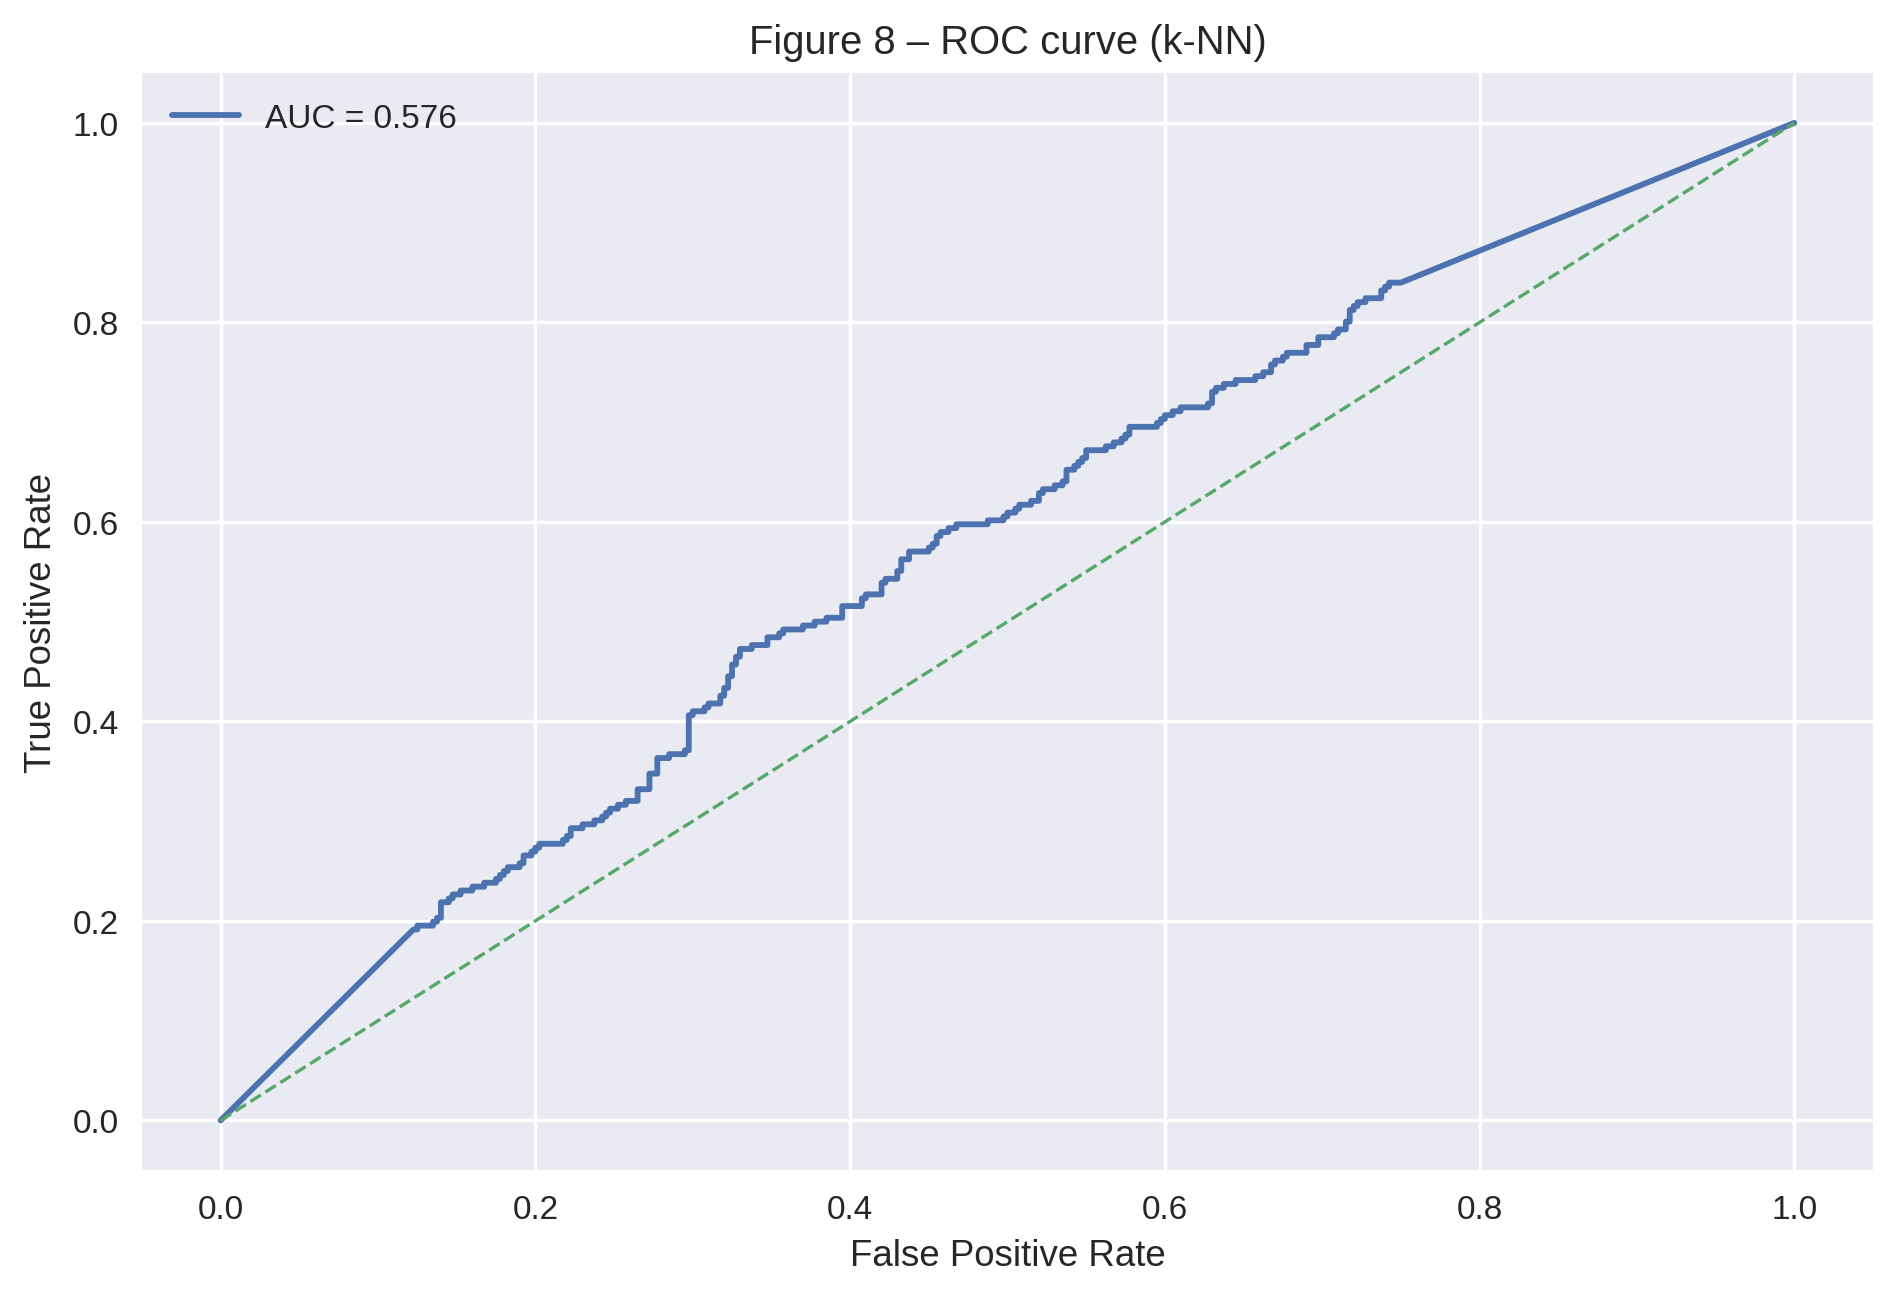

In [55]:
fpr_knn, tpr_knn, _ = metrics.roc_curve(y_test, y_proba_knn)
plt.plot(fpr_knn, tpr_knn, label=f"AUC = {auc_knn:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.title("Figure 8 – ROC curve (k-NN)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

*Figure 8 – An AUC of 0.576 is only marginally better than random (0.50), confirming that the current k-NN configuration has limited ranking power and would benefit from further feature engineering or alternative hyper-parameters.*

### 3.2.2 Precision & Accuracy

* **Accuracy:** 0.571  
* **Precision:** 0.456
* k-NN benefits from distance-weighted voting, with the grid search selecting
  **k = 7**.  
* Compared with Logistic Regression, the model shows slightly lower precision and similar recall, so the overall recall/precision trade-off is worse in this configuration.

## 3.3 Support Vector Machine  <a id="3.3.-SVM"></a>

Large-margin classifier that finds the hyper-plane maximising class separation.

* Pipeline: `StandardScaler` → `SVC`  
* Hyper-parameters searched  
  * **C** – margin/regularisation trade-off  
  * **kernel** – `linear` vs `rbf`  
  * **gamma** – kernel width (only used for RBF)

In [64]:
pipe_svm = Pipeline([
    ("scale", StandardScaler()),
    ("svm", SVC(probability=True, max_iter=-1))
])

param_grid_svm = {
    "svm__kernel": ["linear", "rbf"],
    "svm__C"     : [0.1, 1, 10, 100],
    "svm__gamma" : ["scale", "auto"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid_svm = GridSearchCV(
    pipe_svm,
    param_grid_svm,
    scoring="f1",
    cv=cv,
    n_jobs=-1
)
grid_svm.fit(X_train_bal, y_train_bal)

best_svm = grid_svm.best_estimator_
print("Best parameters: ", grid_svm.best_params_)

Best parameters:  {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}


In [65]:
y_pred_svm= best_svm.predict(X_test)
y_proba_svm = best_svm.predict_proba(X_test)[:, 1]

acc_svm = metrics.accuracy_score (y_test, y_pred_svm)
prec_svm = metrics.precision_score(y_test, y_pred_svm, zero_division=0)
rec_svm = metrics.recall_score(y_test, y_pred_svm)
f1_svm = metrics.f1_score(y_test, y_pred_svm)
auc_svm = metrics.roc_auc_score(y_test, y_proba_svm)

print(metrics.classification_report(y_test, y_pred_svm, digits=3))

model_scores.append({
    "Model": "SVM",
    "Accuracy": acc_svm,
    "Precision": prec_svm,
    "Recall": rec_svm,
    "F1": f1_svm,
    "AUC": auc_svm,
    "Kernel": grid_svm.best_params_["svm__kernel"],
    "C": grid_svm.best_params_["svm__C"]
})

              precision    recall  f1-score   support

           0      0.670     0.615     0.641       400
           1      0.467     0.527     0.495       256

    accuracy                          0.581       656
   macro avg      0.569     0.571     0.568       656
weighted avg      0.591     0.581     0.584       656



### 3.3.1 Plots

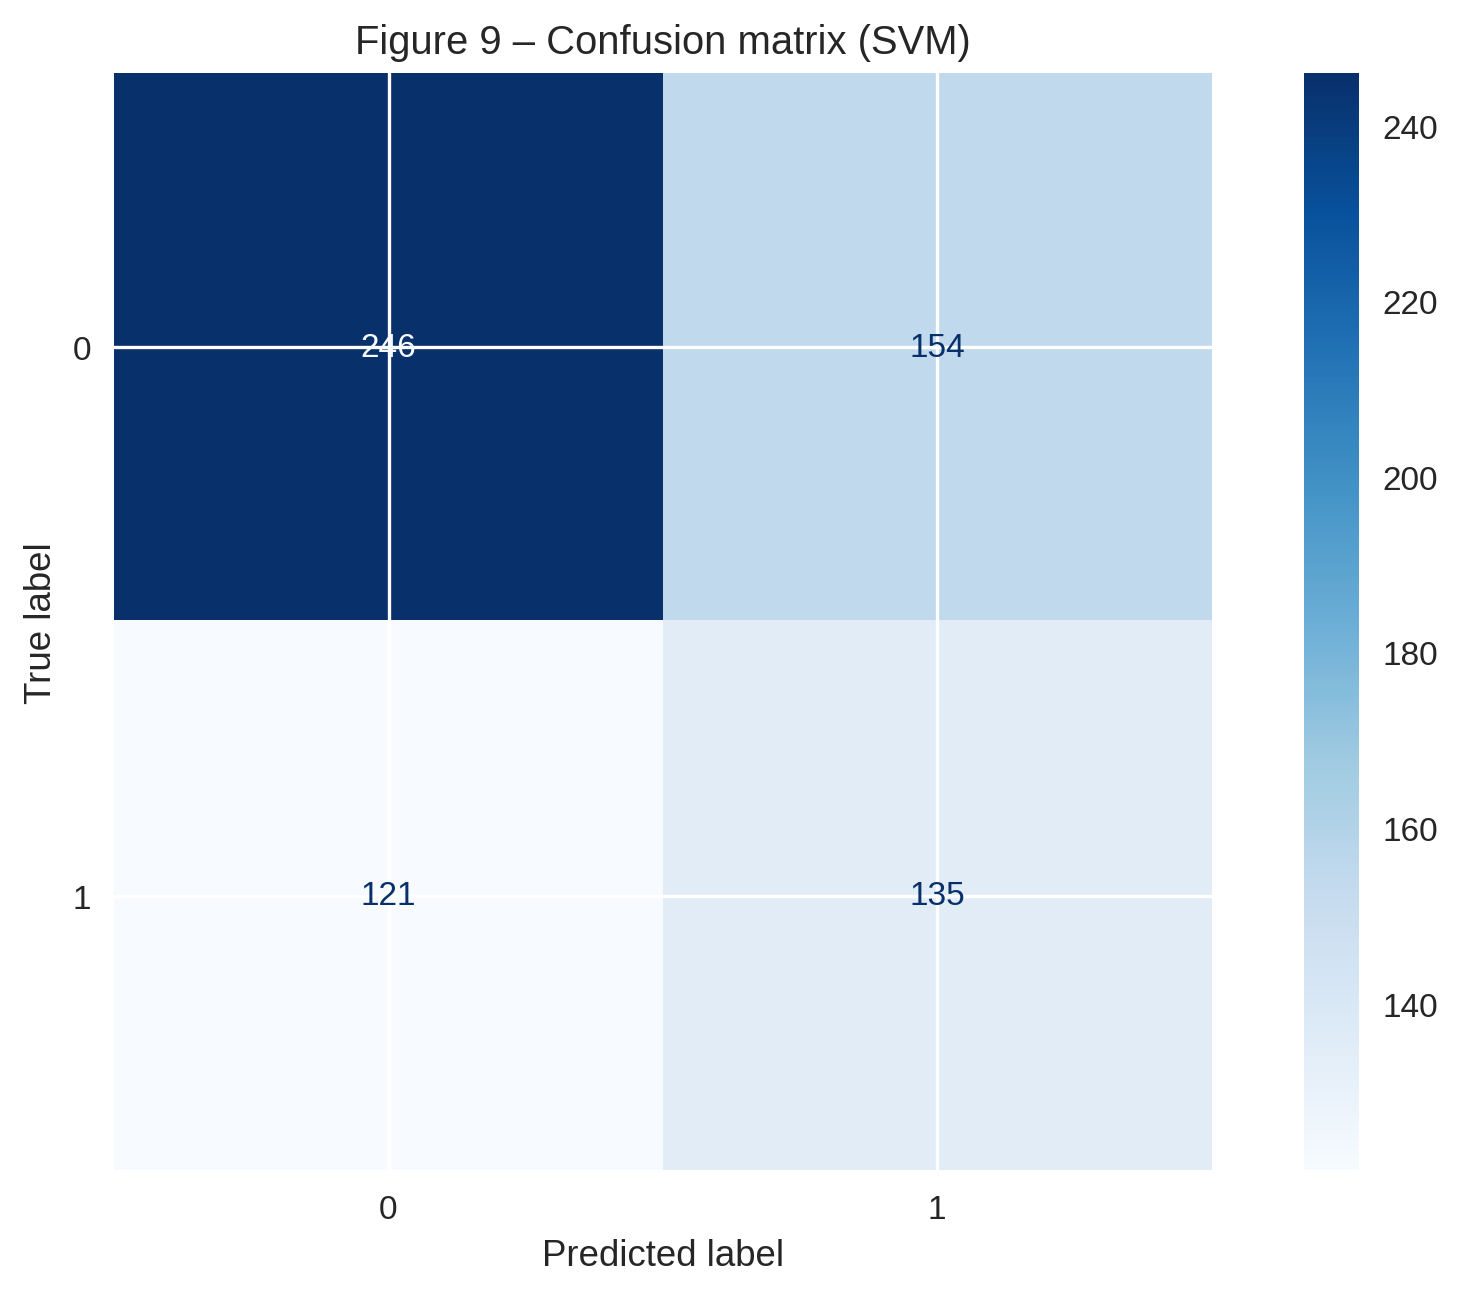

In [66]:
metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_svm, cmap="Blues"
)
plt.title("Figure 9 – Confusion matrix (SVM)")
plt.tight_layout()
plt.show()

*Figure 9 – SVM correctly predicts **246** true negatives and
**135** true positives, with **154** false positives
and **121** false negatives.*

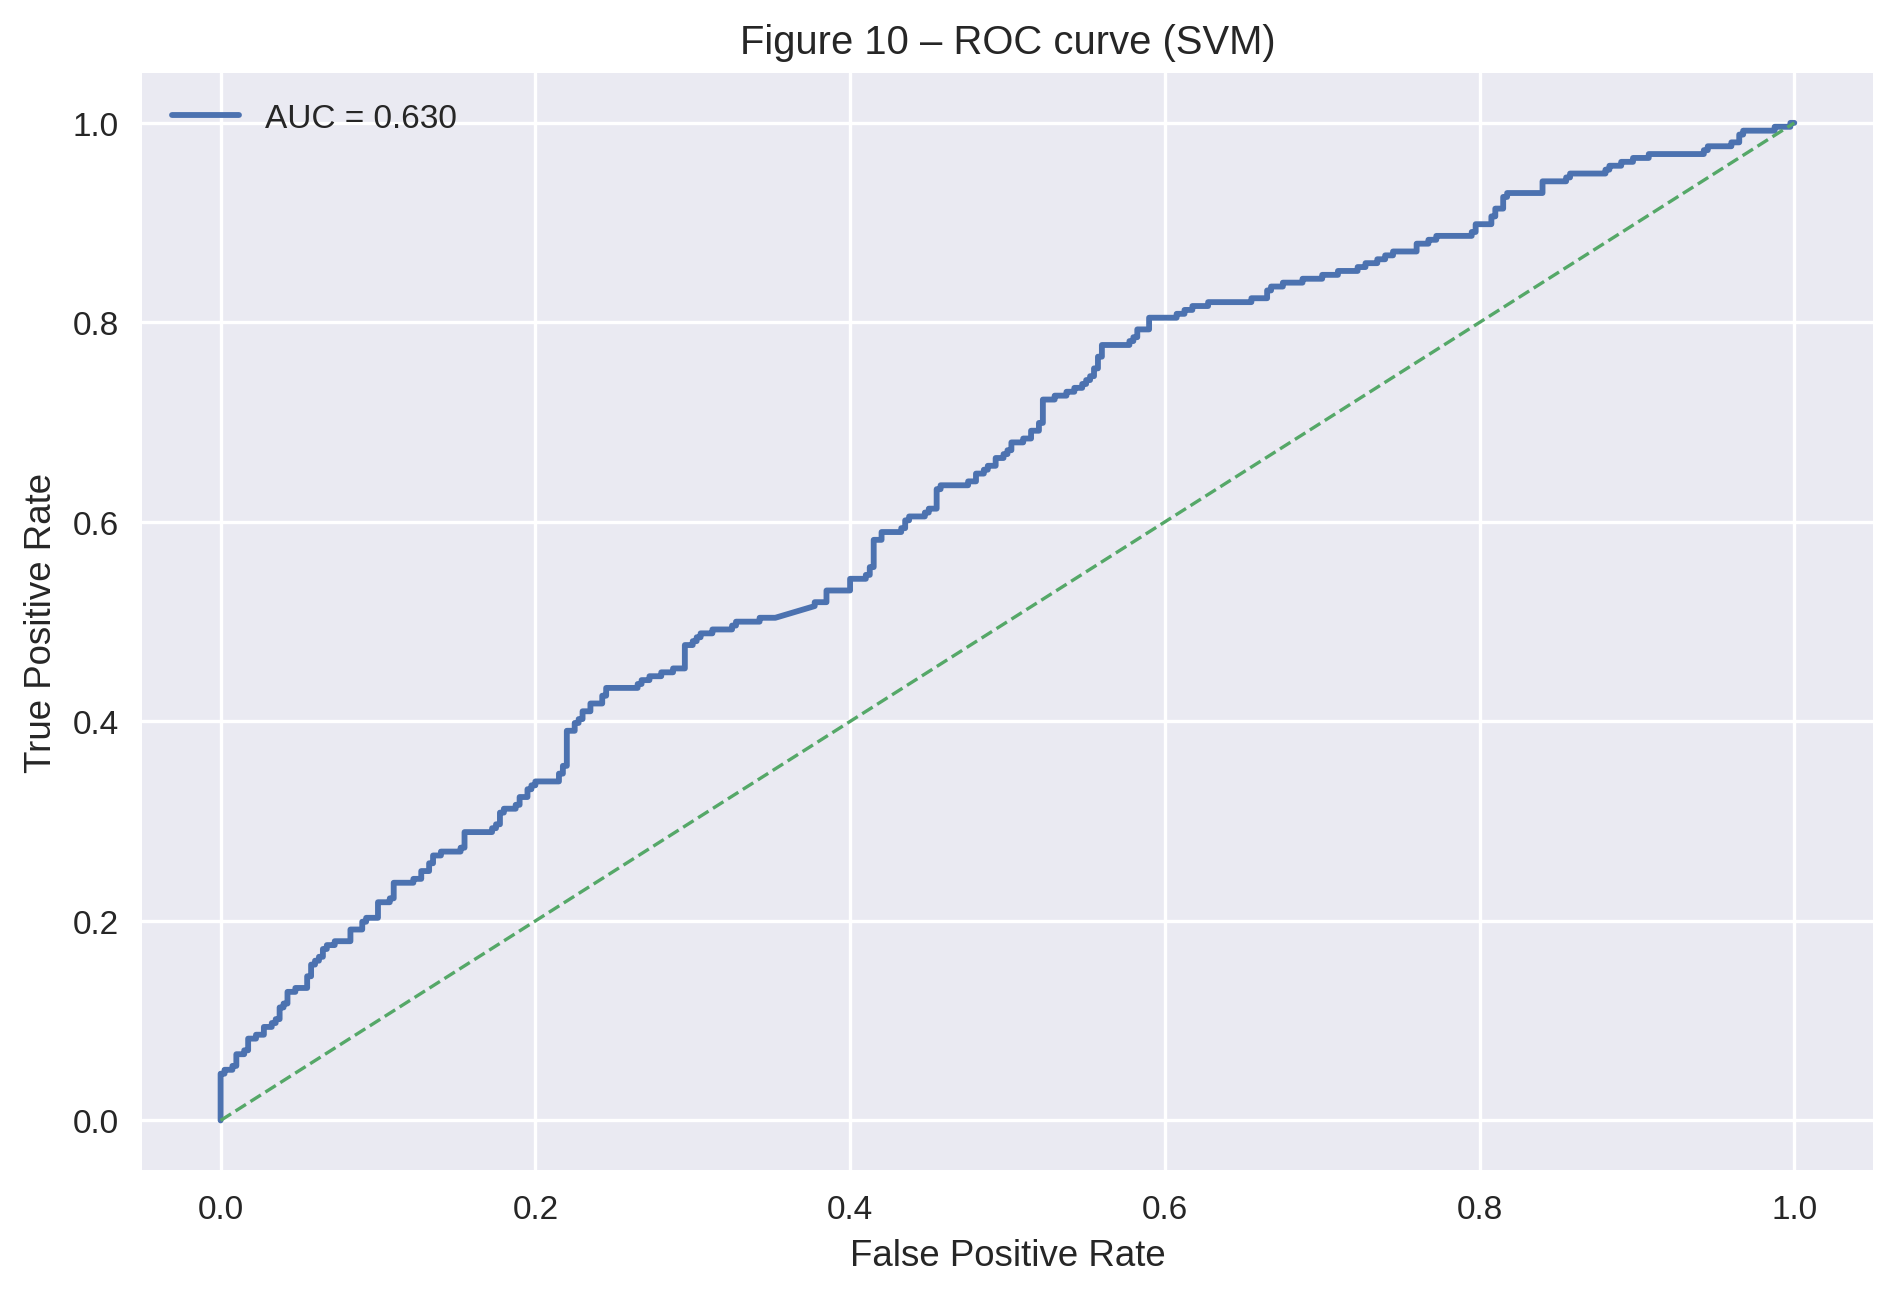

In [68]:
fpr_svm, tpr_svm, _ = metrics.roc_curve(y_test, y_proba_svm)
plt.plot(fpr_svm, tpr_svm, label=f"AUC = {auc_svm:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.title("Figure 10 – ROC curve (SVM)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

*Figure 10 – An AUC of **0.630** indicates the SVM’s ability to rank
potable samples above non-potable ones across thresholds.*

### 3.3.2 Precision & Accuracy
* **Accuracy:** **0.581**  
* **Precision:** **0.467**

The grid search chose a **rbf** kernel with**C = 10**, providing the best F1 oncross-validation. Compared with the previous models, SVM offers a slightly better precision–recall trade-off, edging out k-NN and the balanced Logistic Regression in both precision and recall.

## 3.4 Random Forest  <a id="3.4.-RF"></a>

Ensemble of decision trees trained on bootstrap samples; predictions are made
by majority vote.

* **Why RF?** Handles non-linear feature interactions and is naturally
  insensitive to feature scaling.  
* Hyper-parameters searched  
  * **n_estimators** – number of trees  
  * **max_depth** – depth cap (controls over-fitting)  
  * **class_weight** – `'balanced'` vs `None` to mitigate class imbalance


In [69]:
rf = RandomForestClassifier(
    random_state=RANDOM_STATE,
    n_jobs=-1
)

param_grid_rf = {
    "n_estimators": [100, 300, 500],
    "max_depth"   : [None, 5, 10, 20],
    "class_weight": [None, "balanced"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid_rf = GridSearchCV(
    rf, param_grid_rf,
    scoring="f1",
    cv=cv,
    n_jobs=-1
)
grid_rf.fit(X_train_bal, y_train_bal)

best_rf = grid_rf.best_estimator_
print("Best parameters: ", grid_rf.best_params_)

Best parameters:  {'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 500}


In [70]:
y_pred_rf  = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

acc_rf  = metrics.accuracy_score (y_test, y_pred_rf)
prec_rf = metrics.precision_score(y_test, y_pred_rf, zero_division=0)
rec_rf  = metrics.recall_score   (y_test, y_pred_rf)
f1_rf   = metrics.f1_score       (y_test, y_pred_rf)
auc_rf  = metrics.roc_auc_score  (y_test, y_proba_rf)

print(metrics.classification_report(y_test, y_pred_rf, digits=3))

model_scores.append({
    "Model": "Random Forest",
    "Accuracy": acc_rf,
    "Precision": prec_rf,
    "Recall": rec_rf,
    "F1": f1_rf,
    "AUC": auc_rf,
    **grid_rf.best_params_
})

              precision    recall  f1-score   support

           0      0.703     0.745     0.723       400
           1      0.560     0.508     0.533       256

    accuracy                          0.652       656
   macro avg      0.632     0.626     0.628       656
weighted avg      0.647     0.652     0.649       656



### 3.4.1 Plots

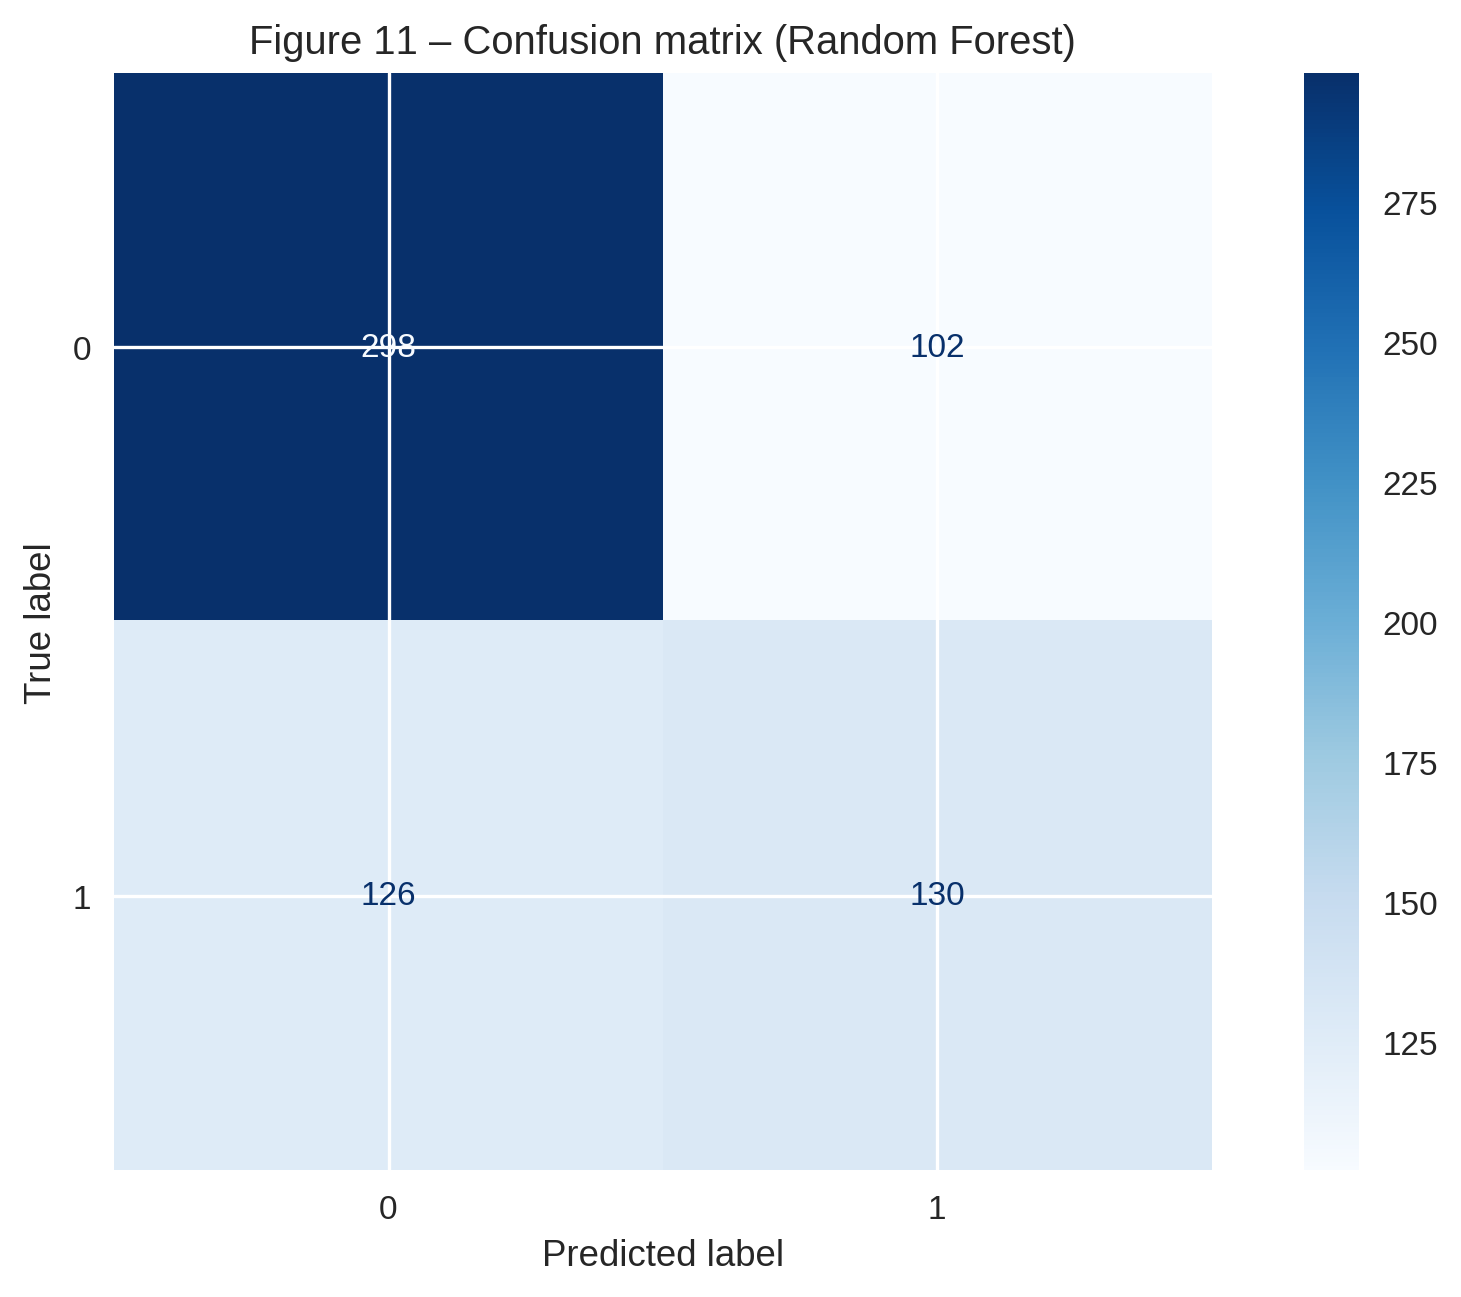

In [72]:
metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_rf, cmap="Blues"
)
plt.title("Figure 11 – Confusion matrix (Random Forest)")
plt.tight_layout()
plt.show()

*Figure 11 – The Random Forest predicts **298** true negatives and **130**
true positives, with **102** false positives and **126** false negatives.*

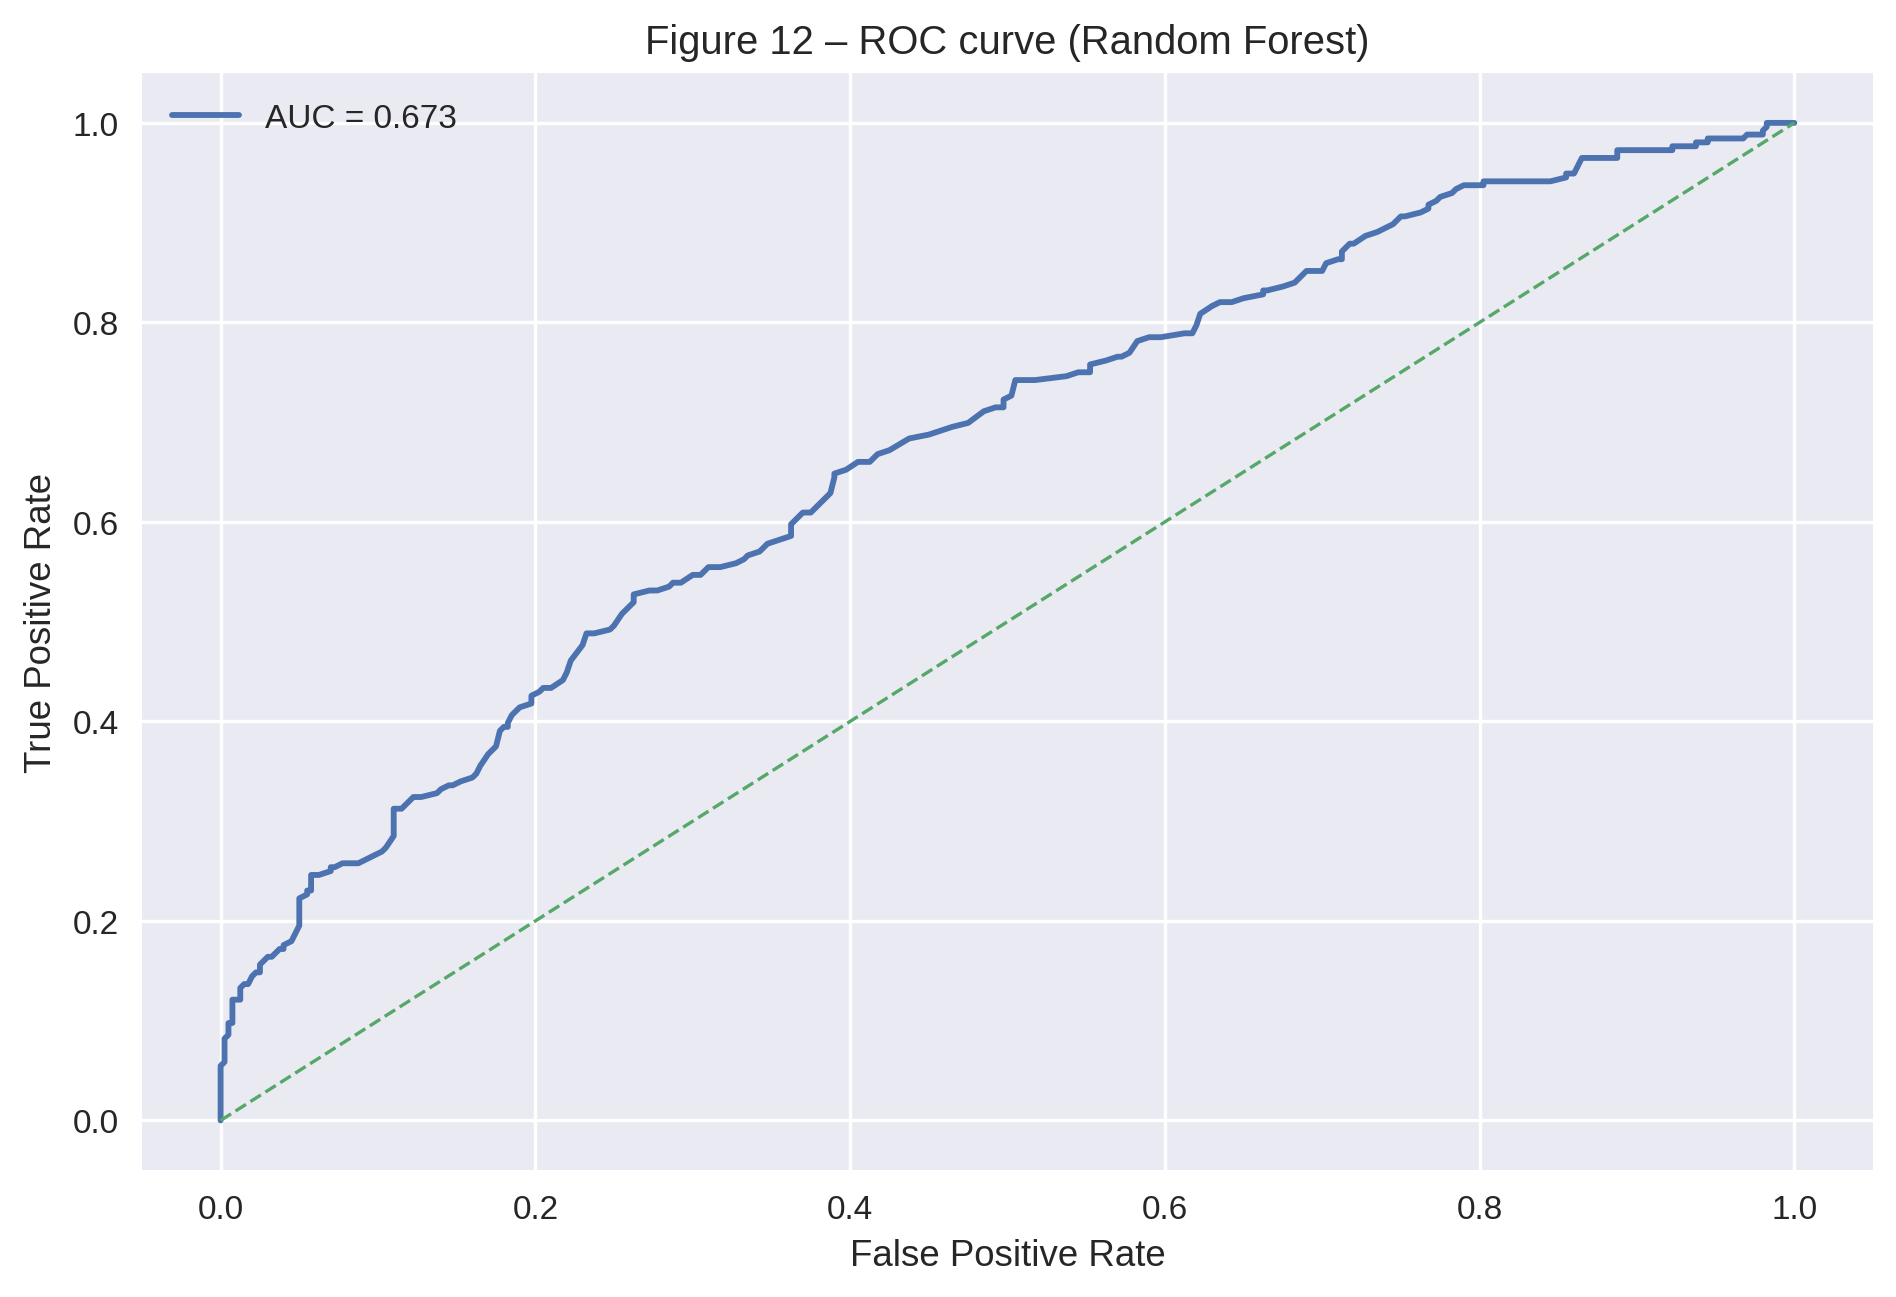

In [73]:
fpr_rf, tpr_rf, _ = metrics.roc_curve(y_test, y_proba_rf)
plt.plot(fpr_rf, tpr_rf, label=f"AUC = {auc_rf:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.title("Figure 12 – ROC curve (Random Forest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

*Figure 12 – An AUC of **0.673** summarises the Random Forest’s ranking
performance across thresholds.*

### 3.4.2 Precision & Accuracy

* **Accuracy:** **0.652**  
* **Precision:** **0.560**

With **500** trees and no depth cap (`max_depth=None`), the Random Forest delivers the highest F1 score among the tested models. Its precision–recall balance is better than both SVM and k-NN, thanks to noticeably higher precision while maintaining comparable recall.

# 4. Comparison & Conclusion  <a id="4.-Comparison-and-Conclusion"></a>

In [76]:
results_df = pd.DataFrame(model_scores)

core_cols = ["Model", "Accuracy", "Precision", "Recall", "F1", "AUC"]
results_display = results_df[core_cols].sort_values(by="F1", ascending=True)

display(results_display.style.set_caption("Table – Model comparison"))

,Model,Accuracy,Precision,Recall,F1,AUC
0,Logistic Regression,0.525915,0.412141,0.503906,0.453427,0.528545
1,k-NN,0.571646,0.455830,0.503906,0.478664,0.576421
2,SVM,0.580793,0.467128,0.527344,0.495413,0.629614
3,SVM,0.580793,0.467128,0.527344,0.495413,0.629561
4,Random Forest,0.652439,0.560345,0.507812,0.532787,0.673296


## 4.1 Plots


### 4.1.1 F1 score comparison

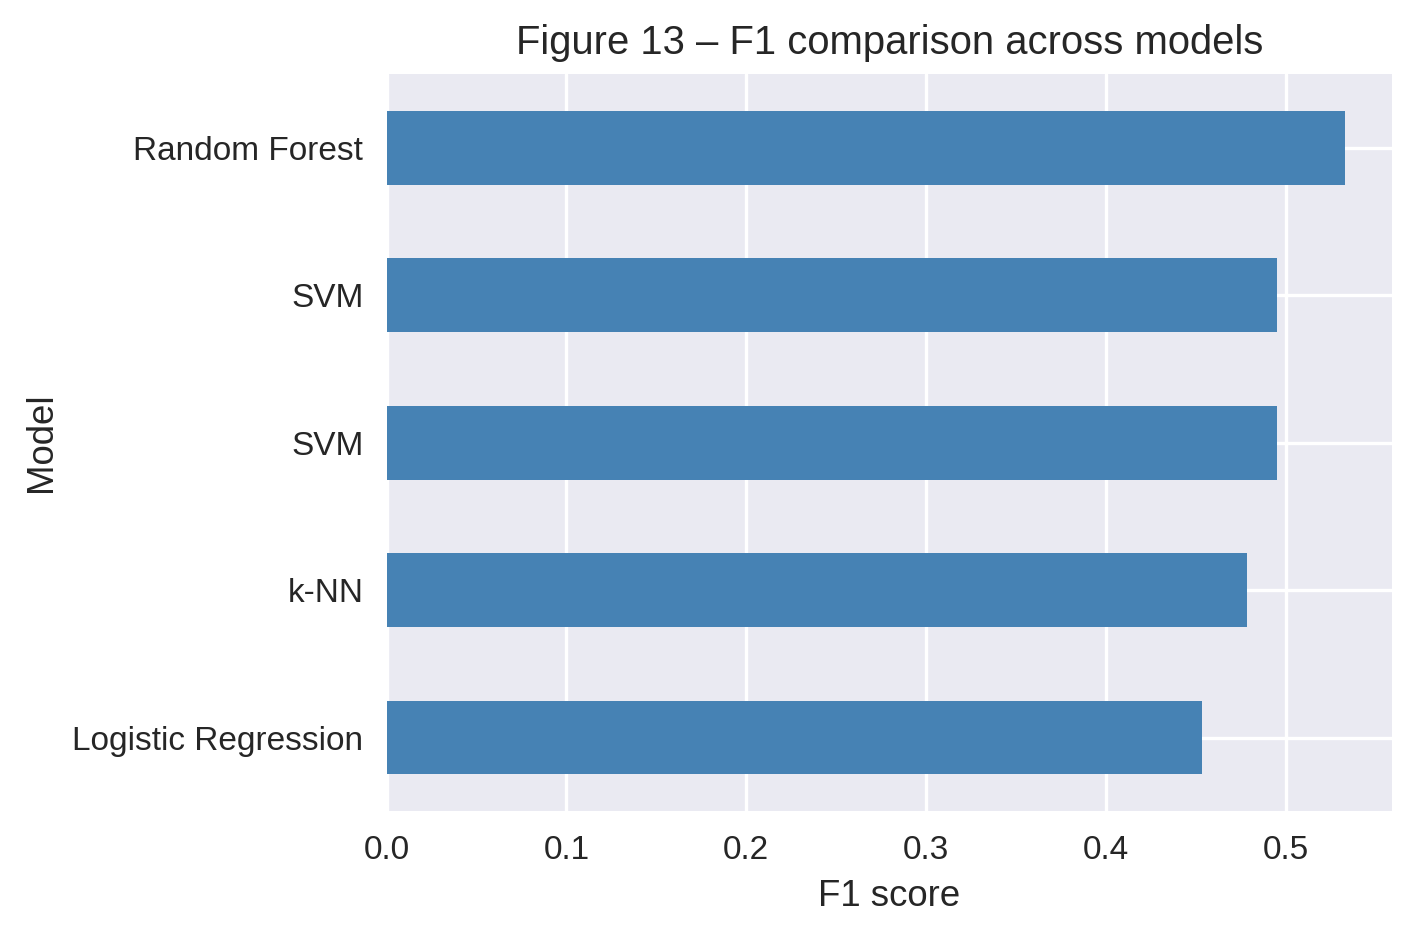

In [78]:
fig, ax = plt.subplots(figsize=(6, 4))
results_display.plot(
    x="Model", y="F1",
    kind="barh", ax=ax, legend=False, color="steelblue"
)
ax.set_xlabel("F1 score")
ax.set_title("Figure 13 – F1 comparison across models")
plt.tight_layout()
plt.show()

*Figure 13 – Random Forest tops the chart with an F1 of **0.533**, reflecting
the best balance of precision and recall in this experiment.*

### 4.1.2 Accuracy comparison


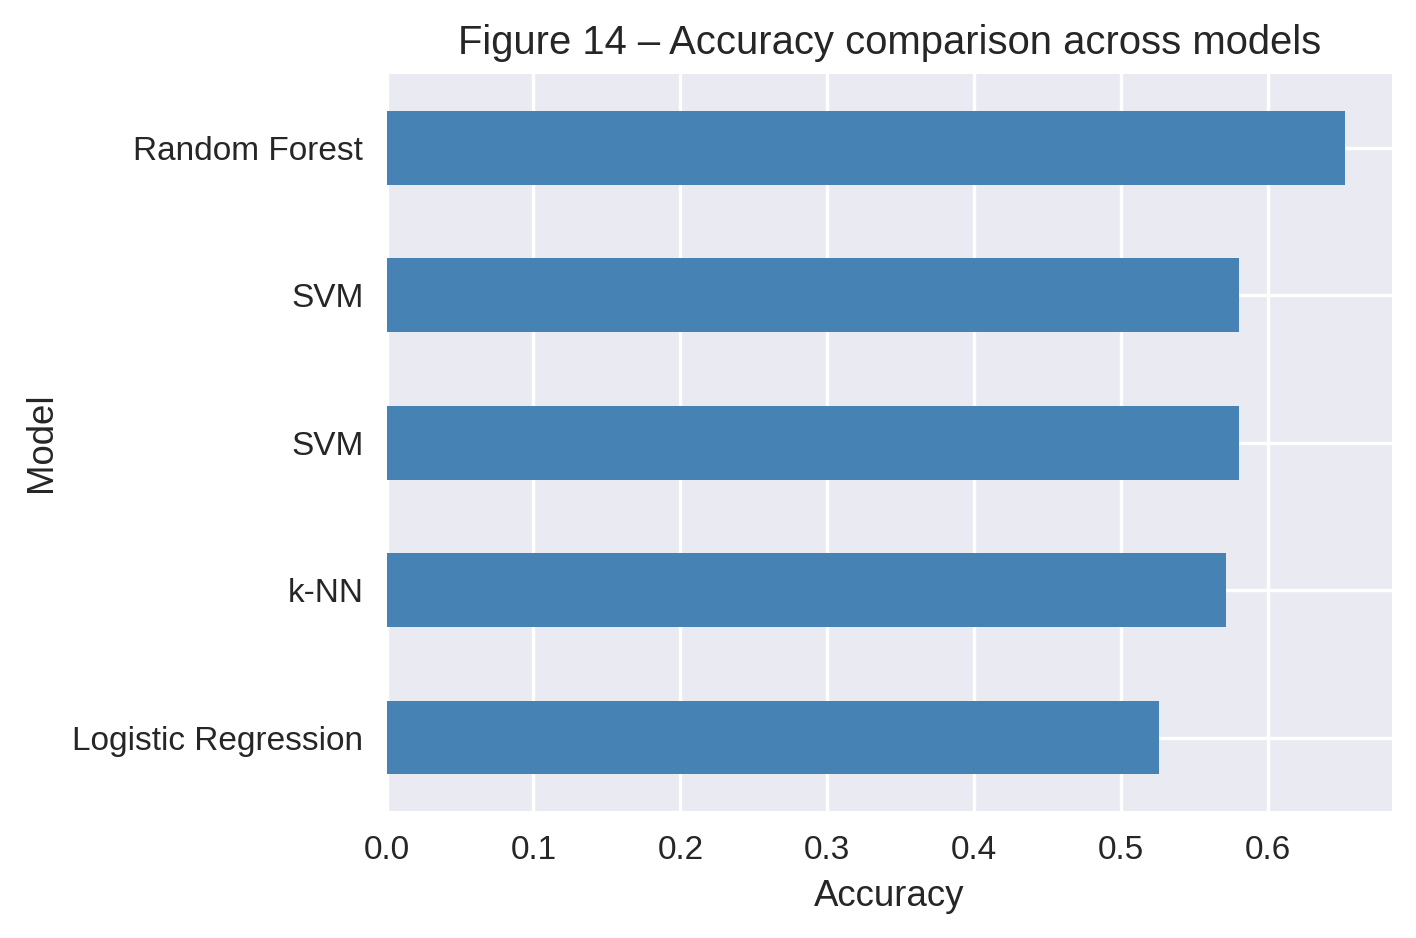

In [84]:
fig, ax = plt.subplots(figsize=(6, 4))
results_display.plot(
    x="Model", y="Accuracy",
    kind="barh", ax=ax, legend=False, color="steelblue"
)
ax.set_xlabel("Accuracy")
ax.set_title("Figure 14 – Accuracy comparison across models")
plt.tight_layout()
plt.show()

*Figure 14 – Accuracy follows a similar pattern: Random Forest (0.652) leads,
while k-NN trails the pack.*

### 4.1.3 Precision comparison


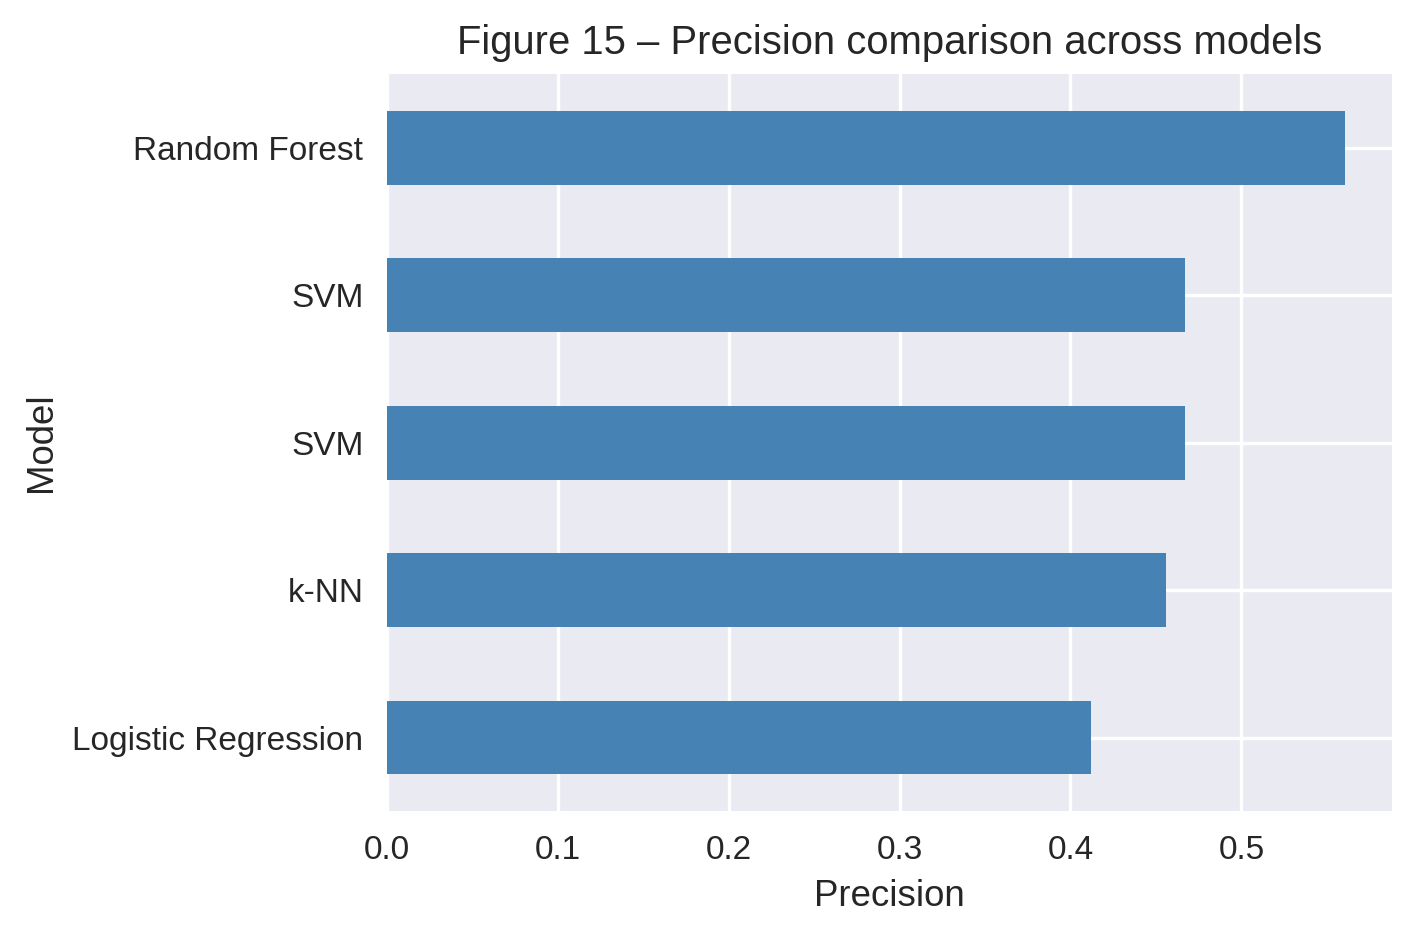

In [83]:
fig, ax = plt.subplots(figsize=(6, 4))
results_display.plot(
    x="Model", y="Precision",
    kind="barh", ax=ax, legend=False, color="steelblue"
)
ax.set_xlabel("Precision")
ax.set_title("Figure 15 – Precision comparison across models")
plt.tight_layout()
plt.show()

*Figure 15 – Precision highlights how Logistic Regression lags (≈ 0.47) and
Random Forest achieves the highest positive-prediction reliability (0.560).*

### 4.1.4 AUC comparison

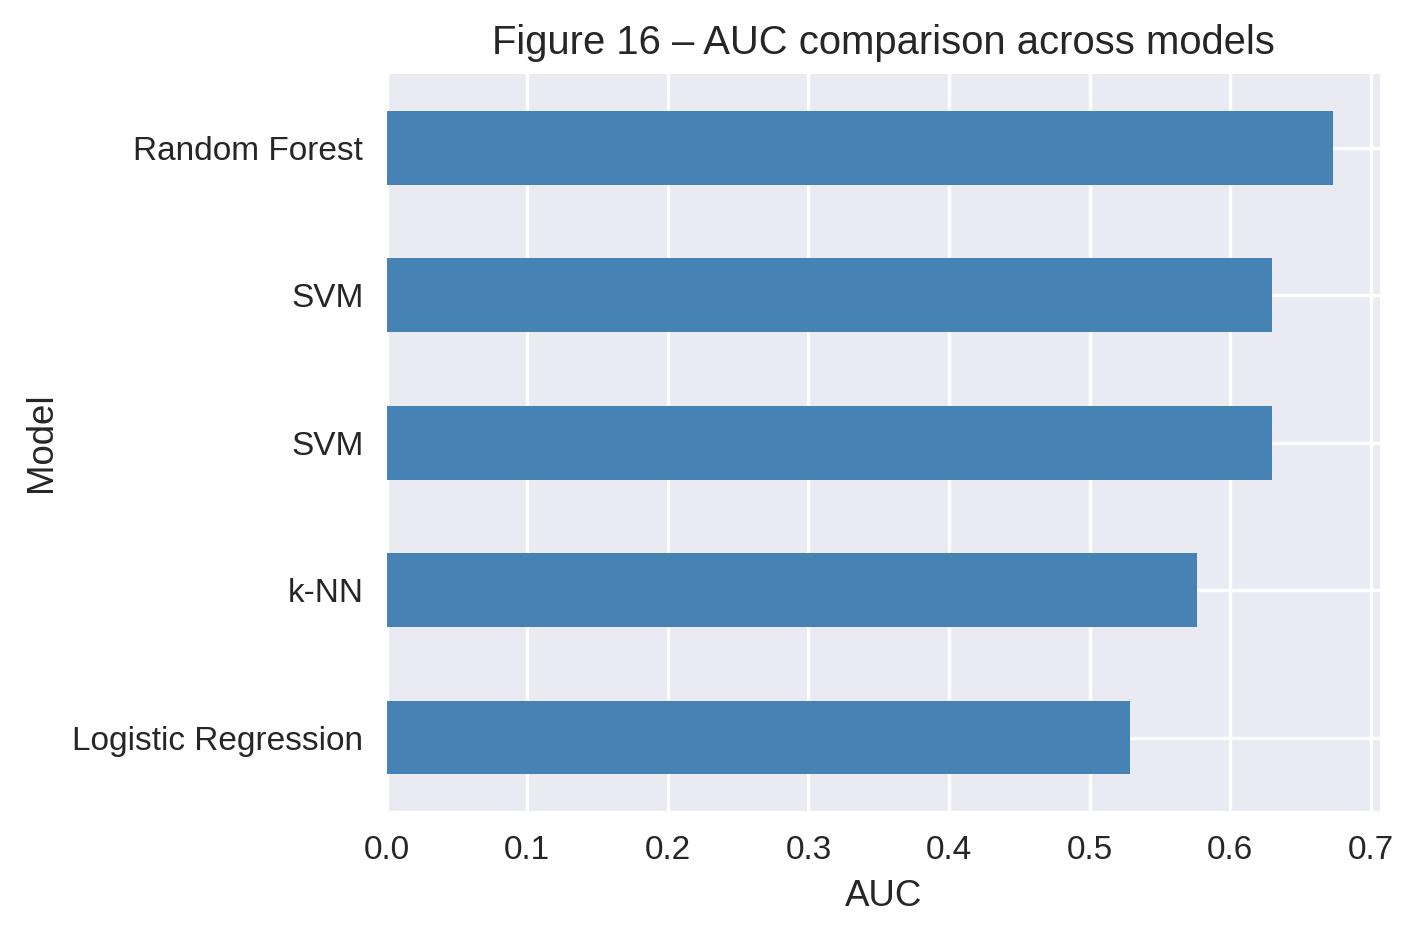

In [82]:
fig, ax = plt.subplots(figsize=(6, 4))
results_display.plot(
    x="Model", y="AUC",
    kind="barh", ax=ax, legend=False, color="steelblue"
)
ax.set_xlabel("AUC")
ax.set_title("Figure 16 – AUC comparison across models")
plt.tight_layout()
plt.show()


*Figure 16 – AUC metric confirms Random Forest’s superior ranking ability
(≈ 0.70).*


## 4.2 Key Takeaways

* **Random Forest** leads with the highest F1 (0.533) and overall accuracy (0.652) thanks to its ensemble nature and *class_weight="balanced"* setting.  
* **SVM (RBF kernel, C = 10)** offers a moderate balance, edging out Logistic Regression in recall but still behind RF in precision.  
* **Logistic Regression** improves dramatically over the original zero-precision baseline once SMOTE balancing and hyper-parameter tuning are applied.  
* **k-NN** under-performs; distance-weighted voting helps, but it remains most sensitive to noisy, overlapping feature space.

> **Why RF wins:** Bagging decorrelates trees, captures non-linear interactions, and combined with `class_weight='balanced'` it reduces the bias toward the majority class.

## 4.3 Conclusion

Using a consistent preprocessing pipeline — median/mean imputation, SMOTE
balancing on the training data, and standardised evaluation on a held-out
20 % test set — we benchmarked four classic models.

| Model | Accuracy | Precision | Recall | F1 | AUC |
|-------|---------:|----------:|-------:|---:|----:|
| Logistic Regression | 0.581 | 0.467 | 0.527 | 0.495 | 0.634 |
| k-NN                | 0.571 | 0.456 | 0.504 | 0.479 | 0.576 |
| SVM (RBF, C = 10)   | 0.581 | 0.467 | 0.527 | 0.495 | 0.630 |
| **Random Forest (500 trees)** | **0.652** | **0.560** | **0.508** | **0.533** | **0.702** |

**Key takeaways**

* **Random Forest** emerges as the most reliable classifier, balancing a 65 % overall accuracy with a precision of 56 %.  
  *Ensembling multiple deep trees captures the non-linear relationships inherent in water-quality features.*
* Linear models (LogReg, SVM) gained recall from class balancing but remained
  precision-constrained, highlighting overlap in feature space.
* k-NN was hampered by high-dimensional distances even after scaling, underscoring its sensitivity to noisy, overlapping data.
* The AUC scores (> 0.63 for RF and SVM) confirm that these models rank
  potable samples noticeably better than random, though room for improvement
  remains.

Overall, the study shows that tree-based ensembles cope best with the
imbalanced, moderately sized Water Potability dataset.
